# Import

**Yatipa's data** ([link](https://drive.google.com/drive/u/1/folders/1XXQ9sNsL4cGfNIfuwmVNxZ9UJUUO6Eu9))




*   maker_vat_calls_ethA_2019-2022.csv
*   ethA-dai-price.csv
*   ethA-dai-price2019-2022



In [ ]:
import heapq
import pandas as pd
import pickle
from datetime import datetime, timedelta, timezone
from tqdm import tqdm, tqdm_notebook
import bisect
from numpy.polynomial import Polynomial
from scipy import optimize
from scipy.special import binom
import numpy as np
from functools import reduce
import math
from math import pi, exp, sqrt
from scipy.integrate import quad
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from mealpy.bio_based import SMA
import random

import cvxpy as cp
import types
from scipy.linalg import cholesky

import warnings
warnings.filterwarnings('ignore')

# Functions

#### Set values and useful functions

In [ ]:
TIME_FORMAT = '%Y-%m-%d %H:%M:%S'
FLIP_ADDR_1 = '0xd8a04F5412223F513DC55F839574430f5EC15531'
FLIP_ADDR_2 = '0xF32836B9E1f47a0515c6Ec431592D5EbC276407f'
TIME_FACTOR = 60        # minutes

global len_frob_fork_ops_0
len_frob_fork_ops_0 = []

global check
check = 0

global flag
flag = 'p_or not converge'

#------------------------------------------------------------------------------------------------------------------

def get_utc_timestamp(time):
    return datetime.strptime(str(time), TIME_FORMAT).replace(tzinfo=timezone.utc)

#------------------------------------------------------------------------------------------------------------------

def print_ffo():
    global len_frob_fork_ops_0
    return len_frob_fork_ops_0

#### filter_ethA_data

In [ ]:
def filter_ethA_data(ethA):
    ethA_filtered = ethA[
        (ethA['fn_name'] == 'grab')
        |
        (
            (ethA['fn_name'] == 'flux')
            &
            (
                (ethA['src'] == FLIP_ADDR_1)
                |
                (ethA['src'] == FLIP_ADDR_2)
            )
        )
        |
        (
            (ethA['fn_name'] == 'frob')
            &
            (ethA['dart'] != 0.0)
        )
        |
        (
            (ethA['fn_name'] == 'fork')
            &
            (ethA['dart'] != 0.0)
        )
    ]

    ethA_filtered = ethA_filtered.astype({ 'rate': 'float' })

    fork_df = ethA_filtered[
        ethA_filtered['fn_name'] == 'fork'
    ]

    def decode(row):
        row['usr'] = row['src']
        row['src'] = None

        row['dart'] = -row['dart']

        return row

    fork_df_inv = fork_df.apply(decode, axis=1)

    return pd.concat([ethA_filtered, fork_df_inv], axis=0).sort_index()

#### cluster_by_ops

In [ ]:
## indecies of df should be reseted

def cluster_by_ops(df):
    prev_fn = None

    grab_flux_ops = []
    frob_fork_ops = []
    prev_frob_fork_ops = []

    for index, row in df.iterrows():
        fn = row['fn_name']
        src = row['src']

        if fn == 'grab':
            if (prev_fn == 'grab' or prev_fn == 'flux'):
                grab_flux_ops.append(row)
                continue

            if grab_flux_ops:
                yield (prev_frob_fork_ops, grab_flux_ops)

            grab_flux_ops = []
            prev_frob_fork_ops = frob_fork_ops
            frob_fork_ops = []

            grab_flux_ops.append(row)

        elif fn == 'flux':
            grab_flux_ops.append(row)

        else:
            frob_fork_ops.append(row)

        prev_fn = fn


    yield (prev_frob_fork_ops, grab_flux_ops)

    if frob_fork_ops:  # frob_fork_ops not null == true
        yield (frob_fork_ops, [])

#### handle_grab_flux

In [ ]:
def handle_grab_flux(grab_flux_ops):
    dink_dai = 0
    flux_dai = 0
    dart_dai = 0
    total_dart = 0

    for row in grab_flux_ops:
        fn_name = row['fn_name']
        time = get_utc_timestamp(row['timestamp']).timestamp()

        if fn_name == 'grab':
            fold_rate = row['rate'] #/ 1e27
            dart = row['dart'] #/ 1e18
            total_dart += dart

            dtab = dart * fold_rate
            dart_dai += -dtab

            dink = -1 * row['dink'] #/ 1e18

            ex_rate_updated = daieth2[daieth2['timestamp_f']>=time]['dai/eth'].iloc[0]
            dink_dai += (dink * ex_rate_updated)
            # dink_dai += (dink * eth_dai_rate.find_lt(time))

        if fn_name == 'flux':
            wad = row['wad'] #/ 1e18
            # ex_rate = eth_dai_rate.find_lt(time)
            ex_rate_updated = daieth2[daieth2['timestamp_f']>=time]['dai/eth'].iloc[0]
            flux_dai += (wad * ex_rate_updated)


    lgd = (dink_dai - flux_dai) - dart_dai

    return lgd, total_dart

#### handle_frob_fork

In [ ]:
def handle_frob_fork(frob_fork_ops):
    total_dart = 0
    prev_time = get_utc_timestamp(frob_fork_ops[0]['timestamp']).timestamp()
    params = []

    for row in frob_fork_ops:
        time = get_utc_timestamp(row['timestamp']).timestamp()
        dtime = (time - prev_time) / TIME_FACTOR
        prev_time = time

        fold_rate = row['rate'] #/ 1e27
        dart = row['dart'] #/ 1e18

        total_dart += dart

        dtab = dart * fold_rate

        params.append((dtab, dtime))

    return params, total_dart

#### calculate_interest

In [ ]:
def calculate_interest(params, init_tab):
    global flag
    def p_or(x):
        total = init_tab
        for dtab, dt in params:
            total = (total * ((1 + x) ** dt) + dtab)

        return total

    def p(F, scale_factor):
        # print('#-------')
        # print(f'\ninit_tab = {init_tab}')
        total = init_tab
        for dtab, dt in params:
            # print(f'dt = {dt}')
            # print(f'dtab = {dtab}')
            dT = dt / scale_factor
            total = (total * (F ** dT) + dtab)

        return total
    # print(params)
    scale_factor = 20.0

    try:
        F = optimize.newton(lambda x: p(x, scale_factor), 1.0, maxiter=1000, tol=1e-10)
#         print(F)
        r = 2 ** (np.log2(F) / scale_factor) - 1
        r_first = r
#         print(r)
    except:
        r = 'Not converge'

    if r!='Not converge':
        p_or_r = p_or(r)
        if abs(p_or_r) > 1e-4:
            scale_factor = 30.0
            try:
                F = optimize.newton(lambda x: p(x, scale_factor), 1.1, maxiter=1000, tol=1e-10)
                r = 2 ** (np.log2(F) / scale_factor) - 1
            except:
                print(flag, params, init_tab)
                # r = 'Not converge p_or'
                r = r_first

    return r

#### split_frob_fork_ops

In [ ]:
def split_frob_fork_ops(fork_frob_ops, init_art=0.0):
    def sum(acc, x):
        val = acc[-1] + x[1]['dart']
        acc.append(val)

        return acc

    vals = reduce(sum, fork_frob_ops.iterrows(), [0,])     # apply a particular function passed in its argument to all of the list elements
    zeros = np.isclose(vals[1:], 0, atol=10, rtol=0)
    zeros = np.where(zeros == True)
    zeros = [x for x in zeros[0]]
    zeros.append(-1)

    loans = []
    prev_pos = 0
    index = ['usr', 'start', 'end', 'status', 'duration (mins)'] ##, 'interest rate', 'LGD']
    for pos in zeros:
        loan = None
        status = None
        if pos != -1:
            loan = fork_frob_ops.iloc[prev_pos:pos+1]
            status = 'finished'
        else:
            loan = fork_frob_ops.iloc[prev_pos:]
            status = 'active'
            if len(loan) == 0:
                continue

        prev_pos = pos+1

        start = loan.iloc[0]['timestamp']
        end = loan.iloc[-1]['timestamp']
        duration_finished =  (get_utc_timestamp(end).timestamp() - get_utc_timestamp(start).timestamp()) / TIME_FACTOR
        usr = loan.iloc[0]['usr']
        data = [usr, start, end, status, duration_finished]
        loans.append(pd.Series(data=data, index=index))

    return loans

#### get_results

In [ ]:
def get_results(df):
    global len_frob_fork_ops_0
    global check
    art = 0
    for frob_fork_ops, grab_flux_ops in cluster_by_ops(df):

        # print(len(frob_fork_ops), len(grab_flux_ops))

        if len(frob_fork_ops)==0:
            nums = (0, len(grab_flux_ops))
            len_frob_fork_ops_0.append((nums, df['usr'].iloc[0]))
            continue

        index = ['usr', 'start', 'flag time', 'end', 'status', 'interest rate', 'LGD', 'duration (mins)']
        start = frob_fork_ops[0]['timestamp']
        vault = frob_fork_ops[0]['usr']
        end = None

        if not grab_flux_ops:    # grab_flux_ops = [] --> none
            data = [vault, start, None, end, 'active', None, None, None]
            yield pd.Series(data=data, index=index)
            continue

        init_rate = frob_fork_ops[0]['rate']
        init_tab = art * init_rate

        params, dart_ff = handle_frob_fork(frob_fork_ops)
        lgd, dart_gf = handle_grab_flux(grab_flux_ops)

        art += dart_ff

        last_time_ff = get_utc_timestamp(frob_fork_ops[-1]['timestamp']).timestamp()
        first_time_gf = get_utc_timestamp(grab_flux_ops[0]['timestamp']).timestamp()
        dtime = (first_time_gf - last_time_ff) / TIME_FACTOR
        flag_time_i = grab_flux_ops[0]['timestamp']

        duration_default = (first_time_gf - get_utc_timestamp(frob_fork_ops[0]['timestamp']).timestamp())/TIME_FACTOR

        rate = grab_flux_ops[0]['rate']
        tab = art * rate

        if init_tab < 0:
            check += 1

        params.append((-(tab + lgd), dtime))
        r = calculate_interest(params, init_tab)
        # if type(r) != str:
        #     if (r < 0)&(lgd > 0):
        #         print(params)
        #         print(init_tab)
        #         print()


        end = grab_flux_ops[-1]['timestamp']

        data = [vault, start, flag_time_i, end, 'default', r, lgd, duration_default]
        yield pd.Series(data=data, index=index)

        art += dart_gf


# Data Pre-processing

## vat_E

In [ ]:
def get_utc_time(time, format_t):
    t_ime = datetime.strptime(str(time), format_t).replace(tzinfo=timezone.utc)
    time_a = t_ime.timestamp()
    return time_a

def to_date(time, format_t):
    timestamp = datetime.fromtimestamp(time)
    return timestamp.strftime(format_t)

In [ ]:
# vat_E_pam = pd.read_csv('/content/drive/MyDrive/1_thesis/old_data/maker_vat_calls_ethA_2019-2022.csv').drop(columns=['Unnamed: 0','state','Unnamed: 0.1'])
# vat_E_pam = vat_E_pam[vat_E_pam['usr'].notna()]
# vat_E_pam['dart'] = vat_E_pam['dart'] / 1e18
# vat_E_pam['dink'] = vat_E_pam['dink'] / 1e18
# vat_E_pam['wad'] = vat_E_pam['wad'] / 1e18
# vat_E_pam['rate']  = vat_E_pam['rate'].astype({ 'rate': 'float' })
# vat_E_pam['rate'] =vat_E_pam['rate'] / 1e27
# vat_E_pam = vat_E_pam.drop_duplicates()
# vat_E_pam['time_f'] = vat_E_pam['timestamp'].apply(lambda x: get_utc_time(x, '%Y-%m-%d %H:%M:%S UTC'))
# vat_E_pam['timestamp'] = vat_E_pam['time_f'].apply(lambda x: to_date(x, '%Y-%m-%d %H:%M:%S'))
# vat_E_pam = vat_E_pam.sort_values(by='timestamp')
# vat_E_pam = vat_E_pam.reset_index(drop=True)

In [ ]:
!pwd

/mnt/SSD/mikhail.evdokimov


In [ ]:
my_global_path = "/mnt/SSD/mikhail.evdokimov/datasets/CourseWork/Data"

In [ ]:
vat_E = pd.read_csv(my_global_path + '/MakerDao_data_2019_2023_latest_update.csv').drop(columns=['Unnamed: 0', 'state'])
print(vat_E.shape)
vat_E.head(5)

(542670, 9)


fn_name    ilk                                         usr  \
0    frob  ETH-A  0x4D7770ce9679ac53C32760b52637195F4421C253   
1    frob  ETH-A  0x9fDc236BB08B80b5aB3D3bf7140b5068cC2EA88a   
2    frob  ETH-A  0x7097Bd26dB93B34c2E95112ABd75C00A1E5BDd9E   
3    frob  ETH-A  0xec76aEB63c0040D3C0AdF7990e43AB146B133606   
4    frob  ETH-A  0xDB47695103dc0a2645A25B8F11EA0a5c03FE52E8   

                                          src            timestamp  dart  \
0  0x4D7770ce9679ac53C32760b52637195F4421C253  2019-11-13 21:22:33   0.0   
1  0x9fDc236BB08B80b5aB3D3bf7140b5068cC2EA88a  2019-11-13 21:45:03   0.0   
2  0x7097Bd26dB93B34c2E95112ABd75C00A1E5BDd9E  2019-11-13 22:07:52   0.0   
3  0xec76aEB63c0040D3C0AdF7990e43AB146B133606  2019-11-13 22:09:02   0.0   
4  0xDB47695103dc0a2645A25B8F11EA0a5c03FE52E8  2019-11-13 22:10:04   0.0   

           dink  wad          rate  
0  0.000000e+00  NaN  1.000006e+27  
1  1.000000e+17  NaN  1.000007e+27  
2  1.000000e+17  NaN  1.000009e+27  
3  6.000000e+16  NaN  1.000009e+27  
4  5.000000e+16  NaN  1.000009e+27

In [ ]:
vat_E = vat_E[vat_E['usr'].notna()]
vat_E['dart'] = vat_E['dart'] / 1e18
vat_E['dink'] = vat_E['dink'] / 1e18
vat_E['wad'] = vat_E['wad'] / 1e18
vat_E['rate'] = vat_E['rate'].astype({ 'rate': 'float' })
vat_E['rate'] = vat_E['rate'] / 1e27
vat_E['timestamp'] = vat_E['timestamp'].astype({ 'timestamp': 'datetime64' })

print(f'vat_E shape : {vat_E.shape}')

vat_E shape : (542670, 9)


In [ ]:
vat_E[vat_E.duplicated(keep=False)]

fn_name    ilk                                         usr  \
1329      frob  ETH-A  0x84cA6A6Be07b7147D5A7780eD46C20682e9Df5F5   
1330      frob  ETH-A  0x84cA6A6Be07b7147D5A7780eD46C20682e9Df5F5   
3317      flux  ETH-A  0xd8a04F5412223F513DC55F839574430f5EC15531   
3319      flux  ETH-A  0xd8a04F5412223F513DC55F839574430f5EC15531   
3321      flux  ETH-A  0xd8a04F5412223F513DC55F839574430f5EC15531   
...        ...    ...                                         ...   
533948    frob  ETH-A  0x7edDAC2D4F9A71fe904B7467908946A2ff692ae3   
533949    frob  ETH-A  0x7edDAC2D4F9A71fe904B7467908946A2ff692ae3   
533950    frob  ETH-A  0x7edDAC2D4F9A71fe904B7467908946A2ff692ae3   
536725    frob  ETH-A  0x3568529096552cae98F81B7eEc902AE1a604191B   
536726    frob  ETH-A  0x3568529096552cae98F81B7eEc902AE1a604191B   

                                               src           timestamp  \
1329    0x03A830217c7b562E34E5c248F1EaC09445498F53 2019-11-19 18:21:42   
1330    0x03A830217c7b562E34E5c248F1EaC09445498F53 2019-11-19 18:21:42   
3317    0x78F2c2AF65126834c51822F56Be0d7469D7A523E 2019-11-22 12:09:02   
3319    0x78F2c2AF65126834c51822F56Be0d7469D7A523E 2019-11-22 12:09:02   
3321    0x78F2c2AF65126834c51822F56Be0d7469D7A523E 2019-11-22 12:09:02   
...                                            ...                 ...   
533948  0x7edDAC2D4F9A71fe904B7467908946A2ff692ae3 2022-07-26 03:03:52   
533949  0x7edDAC2D4F9A71fe904B7467908946A2ff692ae3 2022-07-26 03:03:52   
533950  0x7edDAC2D4F9A71fe904B7467908946A2ff692ae3 2022-07-26 03:03:52   
536725  0x3568529096552cae98F81B7eEc902AE1a604191B 2022-09-18 16:44:23   
536726  0x3568529096552cae98F81B7eEc902AE1a604191B 2022-09-18 16:44:23   

                dart  dink  wad      rate  
1329        0.000000   5.0  NaN  1.000637  
1330        0.000000   5.0  NaN  1.000637  
3317             NaN   NaN  0.2  1.000932  
3319             NaN   NaN  1.0  1.000932  
3321             NaN   NaN  0.2  1.000932  
...              ...   ...  ...       ...  
533948   2232.510356   0.0  NaN  1.075023  
533949   2232.510356   0.0  NaN  1.075023  
533950   2232.510356   0.0  NaN  1.075023  
536725  27818.380839   0.0  NaN  1.078424  
536726  27818.380839   0.0  NaN  1.078424  

[9475 rows x 9 columns]

In [ ]:
# vat_E = vat_E.drop_duplicates()
# print(f'vat_E shape after drop duplicate: {vat_E.shape}')

vat_E['time_f'] = vat_E['timestamp'].apply(lambda x: get_utc_time(x, '%Y-%m-%d %H:%M:%S'))

# vat_E = vat_E.reset_index(drop=True)
vat_E.head(3)

fn_name    ilk                                         usr  \
0    frob  ETH-A  0x4D7770ce9679ac53C32760b52637195F4421C253   
1    frob  ETH-A  0x9fDc236BB08B80b5aB3D3bf7140b5068cC2EA88a   
2    frob  ETH-A  0x7097Bd26dB93B34c2E95112ABd75C00A1E5BDd9E   

                                          src           timestamp  dart  dink  \
0  0x4D7770ce9679ac53C32760b52637195F4421C253 2019-11-13 21:22:33   0.0   0.0   
1  0x9fDc236BB08B80b5aB3D3bf7140b5068cC2EA88a 2019-11-13 21:45:03   0.0   0.1   
2  0x7097Bd26dB93B34c2E95112ABd75C00A1E5BDd9E 2019-11-13 22:07:52   0.0   0.1   

   wad      rate        time_f  
0  NaN  1.000006  1.573680e+09  
1  NaN  1.000007  1.573682e+09  
2  NaN  1.000009  1.573683e+09

In [ ]:
vat_E

fn_name    ilk                                         usr  \
0         frob  ETH-A  0x4D7770ce9679ac53C32760b52637195F4421C253   
1         frob  ETH-A  0x9fDc236BB08B80b5aB3D3bf7140b5068cC2EA88a   
2         frob  ETH-A  0x7097Bd26dB93B34c2E95112ABd75C00A1E5BDd9E   
3         frob  ETH-A  0xec76aEB63c0040D3C0AdF7990e43AB146B133606   
4         frob  ETH-A  0xDB47695103dc0a2645A25B8F11EA0a5c03FE52E8   
...        ...    ...                                         ...   
542665    frob  ETH-A  0x70f06DCFdb1ae54BFe8fd8073011bAc9f7bEC1e2   
542666    flux  ETH-A  0x4C227617e1B80b0f2f6DF218098990Fe01CB2b7a   
542667    frob  ETH-A  0x70f06DCFdb1ae54BFe8fd8073011bAc9f7bEC1e2   
542668    frob  ETH-A  0xC294B60c4556A0a8864f6B5836B1e3d2eB7042eD   
542669    frob  ETH-A  0x3b66455a1186b464Ac3912933D6b88F9857E7FB7   

                                               src           timestamp  \
0       0x4D7770ce9679ac53C32760b52637195F4421C253 2019-11-13 21:22:33   
1       0x9fDc236BB08B80b5aB3D3bf7140b5068cC2EA88a 2019-11-13 21:45:03   
2       0x7097Bd26dB93B34c2E95112ABd75C00A1E5BDd9E 2019-11-13 22:07:52   
3       0xec76aEB63c0040D3C0AdF7990e43AB146B133606 2019-11-13 22:09:02   
4       0xDB47695103dc0a2645A25B8F11EA0a5c03FE52E8 2019-11-13 22:10:04   
...                                            ...                 ...   
542665  0x70f06DCFdb1ae54BFe8fd8073011bAc9f7bEC1e2 2023-03-31 15:57:59   
542666  0x70f06DCFdb1ae54BFe8fd8073011bAc9f7bEC1e2 2023-03-31 15:57:59   
542667  0x70f06DCFdb1ae54BFe8fd8073011bAc9f7bEC1e2 2023-03-31 16:23:11   
542668  0xC294B60c4556A0a8864f6B5836B1e3d2eB7042eD 2023-03-31 20:49:59   
542669  0x3b66455a1186b464Ac3912933D6b88F9857E7FB7 2023-03-31 23:05:23   

                 dart    dink   wad      rate        time_f  
0            0.000000    0.00   NaN  1.000006  1.573680e+09  
1            0.000000    0.10   NaN  1.000007  1.573682e+09  
2            0.000000    0.10   NaN  1.000009  1.573683e+09  
3            0.000000    0.06   NaN  1.000009  1.573683e+09  
4            0.000000    0.05   NaN  1.000009  1.573683e+09  
...               ...     ...   ...       ...           ...  
542665       0.000000   -2.19   NaN  1.086979  1.680278e+09  
542666            NaN     NaN  2.19  1.086979  1.680278e+09  
542667   -2782.942110    0.00   NaN  1.086979  1.680280e+09  
542668     919.963987    0.00   NaN  1.086999  1.680296e+09  
542669  114995.057256  239.00   NaN  1.087003  1.680304e+09  

[542670 rows x 10 columns]

In [ ]:
# print(min(vat_E_pam['timestamp']), max(vat_E_pam['timestamp']))
print(min(vat_E['timestamp']), max(vat_E['timestamp']))

2019-11-13 21:22:33 2023-03-31 23:05:23


In [ ]:
# vat_E_pam.describe()

In [ ]:
vat_E.describe()

dart           dink            wad           rate        time_f
count  4.285090e+05  428509.000000  114161.000000  542670.000000  5.426700e+05
mean   8.257491e+02       1.987344     224.825754       1.029123  1.605411e+09
std    1.220960e+06    2322.725376    3400.823863       0.017530  2.160297e+07
min   -2.616900e+08 -446200.000000       0.000000       1.000006  1.573680e+09
25%    0.000000e+00       0.000000       2.000000       1.019572  1.584773e+09
50%    0.000000e+00       0.000000      10.000000       1.021577  1.603666e+09
75%    4.881253e+02       1.000000      48.080198       1.039003  1.619169e+09
max    1.423010e+08  400000.000000  446200.000000       1.087003  1.680304e+09

In [ ]:
print(max(vat_E.isnull().sum(axis=1)))

null_data = {'src': [vat_E['src'].isnull().sum()],
             'dart': [vat_E['dart'].isnull().sum()],
             'dink': [vat_E['dink'].isnull().sum()],
             'wad':  [vat_E['wad'].isnull().sum()],
             'sum': [sum(vat_E.isnull().sum(axis=1))]
            }
df_null = pd.DataFrame(data = null_data, index = ['data'])
df_null

2


src    dart    dink     wad     sum
data  6425  114161  114161  428509  663256

In [ ]:
def to_date(date_t):
  datetime_obj = datetime.strptime(str(date_t), '%Y-%m-%d %H:%M:%S')
  date_i = datetime_obj.date()
  return date_i

df_beer = vat_E.copy()
# df_pam = vat_E_pam.copy()

df_beer['date'] = df_beer['timestamp'].apply(lambda x: to_date(x))
# df_pam['date'] = df_pam['timestamp'].apply(lambda x: to_date(x))

In [ ]:
data_b = df_beer['date'].value_counts()
data_b = pd.DataFrame(data_b)
data_b = data_b.reset_index()
data_b = data_b.rename({'date':'count', 'index': 'date'}, axis=1)
data_b = data_b.sort_values(by='date')
data_b = data_b.reset_index(drop=True)
data_b          # updated day == 1235 - 2 days

date  count
0     2019-11-13      8
1     2019-11-15      2
2     2019-11-17      2
3     2019-11-18    745
4     2019-11-19    798
...          ...    ...
1228  2023-03-27     29
1229  2023-03-28      9
1230  2023-03-29     13
1231  2023-03-30     12
1232  2023-03-31     16

[1233 rows x 2 columns]

In [ ]:
# check days -->  1176 days --> correct!
(data_b['date'][1173] - data_b['date'][0]).days  + 1

1176

In [ ]:
# data_p = df_pam['date'].value_counts()
# data_p = pd.DataFrame(data_p)
# data_p = data_p.reset_index()
# data_p = data_p.rename({'date':'count', 'index': 'date'}, axis=1)
# data_p = data_p.sort_values(by='date')
# data_p = data_p.reset_index(drop=True)
# data_p

In [ ]:
vat_E.to_csv(my_global_path + '/vat_E.csv')

## daieth2

In [ ]:
def get_utc_time(time):
    t_ime = datetime.strptime(str(time), '%Y-%m-%d %H:%M:%S').replace(tzinfo=timezone.utc)
    time_a = t_ime.timestamp()
    return time_a

def to_date(time):
    timestamp = datetime.fromtimestamp(time)
    return timestamp.strftime('%Y-%m-%d %H:%M:%S')

def find_lt(data):
    i = bisect.bisect_left(daieth_rate['timestamp_f'], data)
    return daieth_rate['dai/eth'][i-1]

In [ ]:
eth_dai_rates

[(1573528860, 185.14),
 (1573525920, 185.66),
 (1573523220, 185.02),
 (1573521960, 184.9),
 (1573521840, 184.94),
 (1573520100, 185.44),
 (1573519560, 184.3),
 (1573519500, 184.3),
 (1573519020, 184.3),
 (1573518840, 184.3),
 (1573518780, 184.29),
 (1573518240, 183.98),
 (1573517340, 183.84),
 (1573517160, 183.91),
 (1573545120, 185.85),
 (1573545060, 185.86),
 (1573544880, 185.83),
 (1573543920, 185.46),
 (1573543500, 186.26),
 (1573541280, 186),
 (1573540860, 186.11),
 (1573540740, 185.9),
 (1573539600, 186),
 (1573539420, 186.44),
 (1573539240, 186.11),
 (1573536840, 185.36),
 (1573535340, 185.3),
 (1573534980, 185.01),
 (1573534620, 185.3),
 (1573533600, 185.3),
 (1573532760, 185.3),
 (1573531620, 185.2),
 (1573559160, 185.47),
 (1573559040, 185.3),
 (1573558680, 184.8),
 (1573557000, 185.18),
 (1573555260, 185.41),
 (1573554780, 186.04),
 (1573554660, 185.59),
 (1573554540, 185.56),
 (1573553820, 185.73),
 (1573553520, 185.66),
 (1573553340, 185.72),
 (1573552920, 184.94),
 (15735

In [ ]:
# -------------- file from Yatipa ----------------
eth_dai_rates = None
file_name = my_global_path + '/ethA-dai-price.csv'
with open(file_name, 'rb+') as f:
    eth_dai_rates = pickle.load(f)

eth_dai = pd.DataFrame(eth_dai_rates, columns=['timestamp_f', 'dai/eth'])
eth_dai['dai/eth'] = eth_dai['dai/eth'].astype({ 'dai/eth': 'float' })
eth_dai['timestamp'] = eth_dai['timestamp_f'].apply(lambda x: to_date(x))
eth_dai['timestamp_f'] = eth_dai['timestamp_f'].astype({ 'timestamp_f': 'float' })
eth_dai['timestamp'] = eth_dai['timestamp'].astype({ 'timestamp': 'datetime64' })

eth_dai = eth_dai.sort_values('timestamp')
eth_dai = eth_dai.reset_index(drop=True)
print(min(eth_dai.timestamp))
print(max(eth_dai.timestamp))
eth_dai

2019-11-12 03:06:00
2021-04-21 02:59:00


timestamp_f  dai/eth           timestamp
0       1.573517e+09   183.91 2019-11-12 03:06:00
1       1.573517e+09   183.84 2019-11-12 03:09:00
2       1.573518e+09   183.98 2019-11-12 03:24:00
3       1.573519e+09   184.29 2019-11-12 03:33:00
4       1.573519e+09   184.30 2019-11-12 03:34:00
...              ...      ...                 ...
202461  1.618963e+09  2321.76 2021-04-21 02:50:00
202462  1.618963e+09  2324.48 2021-04-21 02:53:00
202463  1.618963e+09  2326.65 2021-04-21 02:54:00
202464  1.618963e+09  2325.99 2021-04-21 02:55:00
202465  1.618963e+09  2334.35 2021-04-21 02:59:00

[202466 rows x 3 columns]

In [ ]:
# Rate should be --> 'eth_dai'
daieth_rate = pd.read_csv(my_global_path + '/dai_eth_rate_update.csv').drop(columns=['Unnamed: 0'])
daieth_rate = daieth_rate.drop('dai_eth', axis=1)
daieth_rate['timestamp'] = daieth_rate['timestamp'].astype({ 'timestamp': 'datetime64' })
daieth_rate['timestamp_f'] = daieth_rate['timestamp'].apply(lambda x: get_utc_time(x))
daieth_rate = daieth_rate.rename(columns={"eth_dai": "dai/eth"})
daieth_rate = daieth_rate.sort_values('timestamp')
daieth_rate = daieth_rate.reset_index(drop=True)
daieth_rate.head(2)

dai/eth           timestamp   timestamp_f
0  181.439693 2019-11-15 05:05:14  1.573794e+09
1  181.439693 2019-11-15 06:01:24  1.573798e+09

In [ ]:
daieth_rate.tail(2)

dai/eth           timestamp   timestamp_f
29554  1823.01048 2023-03-31 22:01:35  1.680300e+09
29555  1823.01048 2023-03-31 23:01:35  1.680304e+09

In [ ]:
# Append data from Yatipa (date before 2019-11-15 05:05:14 	)
df = eth_dai[eth_dai['timestamp'] <= daieth_rate['timestamp'][0]]
daieth_rate = pd.concat([df, daieth_rate])

daieth_rate = daieth_rate.sort_values('timestamp')
daieth_rate = daieth_rate.reset_index(drop=True)

print(max(daieth_rate.timestamp))
daieth_rate

2023-03-31 23:01:35


timestamp_f      dai/eth           timestamp
0      1.573517e+09   183.910000 2019-11-12 03:06:00
1      1.573517e+09   183.840000 2019-11-12 03:09:00
2      1.573518e+09   183.980000 2019-11-12 03:24:00
3      1.573519e+09   184.290000 2019-11-12 03:33:00
4      1.573519e+09   184.300000 2019-11-12 03:34:00
...             ...          ...                 ...
30317  1.680289e+09  1829.124161 2023-03-31 19:01:35
30318  1.680293e+09  1829.124161 2023-03-31 20:01:35
30319  1.680296e+09  1823.010480 2023-03-31 21:01:35
30320  1.680300e+09  1823.010480 2023-03-31 22:01:35
30321  1.680304e+09  1823.010480 2023-03-31 23:01:35

[30322 rows x 3 columns]

In [ ]:
df.shape[0]

766

In [ ]:
daieth_rate[:793]

timestamp_f     dai/eth           timestamp
0    1.573517e+09  183.910000 2019-11-12 03:06:00
1    1.573517e+09  183.840000 2019-11-12 03:09:00
2    1.573518e+09  183.980000 2019-11-12 03:24:00
3    1.573519e+09  184.290000 2019-11-12 03:33:00
4    1.573519e+09  184.300000 2019-11-12 03:34:00
..            ...         ...                 ...
788  1.573888e+09  180.153487 2019-11-16 07:06:51
789  1.573892e+09  180.153487 2019-11-16 08:07:03
790  1.573895e+09  181.260000 2019-11-16 09:06:44
791  1.573899e+09  181.260000 2019-11-16 10:07:09
792  1.573902e+09  181.260000 2019-11-16 11:06:53

[793 rows x 3 columns]

In [ ]:
daieth_rate[368:380]

timestamp_f  dai/eth           timestamp
368  1.573680e+09   187.43 2019-11-14 00:22:00
369  1.573680e+09   186.93 2019-11-14 00:24:00
370  1.573680e+09   187.15 2019-11-14 00:25:00
371  1.573680e+09   186.53 2019-11-14 00:28:00
372  1.573681e+09   186.51 2019-11-14 00:30:00
373  1.573681e+09   186.40 2019-11-14 00:32:00
374  1.573681e+09   186.50 2019-11-14 00:33:00
375  1.573681e+09   186.27 2019-11-14 00:34:00
376  1.573681e+09   186.86 2019-11-14 00:39:00
377  1.573681e+09   186.70 2019-11-14 00:41:00
378  1.573682e+09   187.06 2019-11-14 00:47:00
379  1.573682e+09   187.09 2019-11-14 00:50:00

In [ ]:
vat_E

fn_name    ilk                                         usr  \
0         frob  ETH-A  0x4D7770ce9679ac53C32760b52637195F4421C253   
1         frob  ETH-A  0x9fDc236BB08B80b5aB3D3bf7140b5068cC2EA88a   
2         frob  ETH-A  0x7097Bd26dB93B34c2E95112ABd75C00A1E5BDd9E   
3         frob  ETH-A  0xec76aEB63c0040D3C0AdF7990e43AB146B133606   
4         frob  ETH-A  0xDB47695103dc0a2645A25B8F11EA0a5c03FE52E8   
...        ...    ...                                         ...   
542665    frob  ETH-A  0x70f06DCFdb1ae54BFe8fd8073011bAc9f7bEC1e2   
542666    flux  ETH-A  0x4C227617e1B80b0f2f6DF218098990Fe01CB2b7a   
542667    frob  ETH-A  0x70f06DCFdb1ae54BFe8fd8073011bAc9f7bEC1e2   
542668    frob  ETH-A  0xC294B60c4556A0a8864f6B5836B1e3d2eB7042eD   
542669    frob  ETH-A  0x3b66455a1186b464Ac3912933D6b88F9857E7FB7   

                                               src           timestamp  \
0       0x4D7770ce9679ac53C32760b52637195F4421C253 2019-11-13 21:22:33   
1       0x9fDc236BB08B80b5aB3D3bf7140b5068cC2EA88a 2019-11-13 21:45:03   
2       0x7097Bd26dB93B34c2E95112ABd75C00A1E5BDd9E 2019-11-13 22:07:52   
3       0xec76aEB63c0040D3C0AdF7990e43AB146B133606 2019-11-13 22:09:02   
4       0xDB47695103dc0a2645A25B8F11EA0a5c03FE52E8 2019-11-13 22:10:04   
...                                            ...                 ...   
542665  0x70f06DCFdb1ae54BFe8fd8073011bAc9f7bEC1e2 2023-03-31 15:57:59   
542666  0x70f06DCFdb1ae54BFe8fd8073011bAc9f7bEC1e2 2023-03-31 15:57:59   
542667  0x70f06DCFdb1ae54BFe8fd8073011bAc9f7bEC1e2 2023-03-31 16:23:11   
542668  0xC294B60c4556A0a8864f6B5836B1e3d2eB7042eD 2023-03-31 20:49:59   
542669  0x3b66455a1186b464Ac3912933D6b88F9857E7FB7 2023-03-31 23:05:23   

                 dart    dink   wad      rate        time_f  
0            0.000000    0.00   NaN  1.000006  1.573680e+09  
1            0.000000    0.10   NaN  1.000007  1.573682e+09  
2            0.000000    0.10   NaN  1.000009  1.573683e+09  
3            0.000000    0.06   NaN  1.000009  1.573683e+09  
4            0.000000    0.05   NaN  1.000009  1.573683e+09  
...               ...     ...   ...       ...           ...  
542665       0.000000   -2.19   NaN  1.086979  1.680278e+09  
542666            NaN     NaN  2.19  1.086979  1.680278e+09  
542667   -2782.942110    0.00   NaN  1.086979  1.680280e+09  
542668     919.963987    0.00   NaN  1.086999  1.680296e+09  
542669  114995.057256  239.00   NaN  1.087003  1.680304e+09  

[542670 rows x 10 columns]

In [ ]:
eth_dai_rate_list = []

for i in tqdm(range(len(vat_E['timestamp']))):
    time = get_utc_time(vat_E['timestamp'][i])
    ex_r = find_lt(time)
    eth_dai_rate_list.append(ex_r)

list_time = list(vat_E['timestamp'])
daieth_rate_pd = pd.DataFrame(list(zip(list_time, eth_dai_rate_list)),columns =['timestamp', 'dai/eth'])
daieth_rate_pd

100%|██████████| 542670/542670 [01:44<00:00, 5189.90it/s]


timestamp      dai/eth
0      2019-11-13 21:22:33   187.430000
1      2019-11-13 21:45:03   186.700000
2      2019-11-13 22:07:52   187.120000
3      2019-11-13 22:09:02   186.660000
4      2019-11-13 22:10:04   186.650000
...                    ...          ...
542665 2023-03-31 15:57:59  1835.900000
542666 2023-03-31 15:57:59  1835.900000
542667 2023-03-31 16:23:11  1835.900000
542668 2023-03-31 20:49:59  1829.124161
542669 2023-03-31 23:05:23  1823.010480

[542670 rows x 2 columns]

In [ ]:
daieth2 = daieth_rate_pd.copy()
daieth2 = daieth2.drop_duplicates(subset=['timestamp'])
daieth2["timestamp"] = daieth2["timestamp"].astype("datetime64")
daieth2['timestamp_f'] = daieth2['timestamp'].apply(lambda x: get_utc_time(x))
daieth2 = daieth2.sort_values('timestamp')
daieth2 = daieth2.reset_index(drop=True)

print(daieth2.shape)
daieth2.head(3)

(300833, 3)


timestamp  dai/eth   timestamp_f
0 2019-11-13 21:22:33   187.43  1.573680e+09
1 2019-11-13 21:45:03   186.70  1.573682e+09
2 2019-11-13 22:07:52   187.12  1.573683e+09

In [ ]:
daieth2.to_csv(my_global_path + '/daieth2.csv')

## Stability fee

In [ ]:
vat_E['timestamp_f'] = vat_E['timestamp'].apply(lambda x: get_utc_time(x))

sf_ethA = pd.read_csv(my_global_path + '/stability_fee_ethA.csv').drop('Unnamed: 0', axis=1)

# map stability fee to vat_E's timestamp
sf_ethA["timestamp"] = sf_ethA["timestamp"].astype("datetime64")
sf_ethA['timestamp_f'] = sf_ethA['timestamp'].apply(lambda x: get_utc_time(x))

sf_rate_list = []
vat_E_time = list(vat_E['timestamp'])
vat_E_time_float = list(vat_E['timestamp_f'])

for i in tqdm(range(len(vat_E_time_float))):
    time = vat_E_time_float[i]
    bisc = bisect.bisect_left(sf_ethA['timestamp_f'], time)
    idx = bisc - 1
    sf_rate = sf_ethA['rate_year'][idx]
    sf_rate_list.append(sf_rate)

sf_rate_pd = pd.DataFrame(list(zip(vat_E_time, vat_E_time_float, sf_rate_list)), columns = ['timestamp', 'timestamp_f', 'sf_rate'])
sf_rate_pd = sf_rate_pd.drop_duplicates(subset=['timestamp'])
sf_rate_pd = sf_rate_pd.reset_index(drop=True)

100%|██████████| 542670/542670 [00:28<00:00, 19069.86it/s]


In [ ]:
sf_rate_pd.head(3)

timestamp   timestamp_f  sf_rate
0 2019-11-13 21:22:33  1.573680e+09     1.04
1 2019-11-13 21:45:03  1.573682e+09     1.04
2 2019-11-13 22:07:52  1.573683e+09     1.04

In [ ]:
sf_rate_pd.tail(3)

timestamp   timestamp_f  sf_rate
300830 2023-03-31 16:23:11  1.680280e+09    1.015
300831 2023-03-31 20:49:59  1.680296e+09    1.015
300832 2023-03-31 23:05:23  1.680304e+09    1.015

In [ ]:
sf_rate_pd.to_csv(my_global_path + '/sf_rate_pd.csv')

## loans - active

get credits of users who weren't liquidated

In [ ]:
vat_E = pd.read_csv(my_global_path + '/vat_E.csv').drop(columns=['Unnamed: 0'])
vat_E['timestamp'] = vat_E['timestamp'].astype({ 'timestamp' : 'datetime64' })

daieth2 = pd.read_csv(my_global_path + '/daieth2.csv').drop(columns=['Unnamed: 0'])
daieth2['timestamp'] = daieth2['timestamp'].astype({ 'timestamp' : 'datetime64' })

sf_rate_pd = pd.read_csv(my_global_path + '/sf_rate_pd.csv').drop(columns=['Unnamed: 0'])
sf_rate_pd['timestamp'] = sf_rate_pd['timestamp'].astype({ 'timestamp' : 'datetime64' })

In [ ]:
ethA = vat_E.copy()
ethA_default = filter_ethA_data(vat_E)

grouped = ethA_default.groupby('usr')
grab = ethA[ethA['fn_name'] == 'grab']
grab_usr = set(grab.groupby('usr').groups.keys())
other_usr = set(grouped.groups.keys()) - grab_usr

#----------------------------------------------------------------------------------------------------------------

# # get credits of users who weren't liquidated
# loans_all = []
# for v in tqdm(other_usr):
#     v_gr = grouped.get_group(v)
#     loans = split_frob_fork_ops(v_gr)
#     loans_all.extend(loans)

# loans_all = pd.DataFrame(loans_all)
# loans_all.to_csv('/content/drive/MyDrive/1_thesis/1_working/data_final/loans_active')
# # loans_all

#----------------------------------------------------------------------------------------------------------------

loans_all = pd.read_csv(my_global_path + '/loans_active.csv').drop(columns=['Unnamed: 0'])
loans_all['start'] = loans_all['start'].astype({ 'start' : 'datetime64' })
loans_all['end'] = loans_all['end'].astype({ 'end' : 'datetime64' })

print(loans_all.shape)
loans_all.head(3)

(21839, 5)


usr               start  \
0  0xa1f7Ed4e707e135367F4A142fe1d591Bc9dF3957 2020-11-15 07:02:48   
1  0x0F7F7c49c5A6ce2f6921EFBAA58C5847CCBA85Ea 2020-06-06 20:40:05   
2  0x0f466777e5c7362B5f01051FC0aA39c9E50F84A0 2020-04-22 15:54:57   

                  end    status  duration (mins)  
0 2021-12-13 07:28:08  finished    565945.333333  
1 2020-10-15 18:33:38  finished    188513.550000  
2 2020-06-23 18:30:11  finished     89435.233333

## loans - liquidate

get credits of users who were **liquidated** at least once!

In [ ]:
stat = []

# get credits of users who were liquidated at least once
for vault in tqdm(grab_usr):
    group = grouped.get_group(vault)

    stat.extend(
        [row for row in get_results(group)]
    )

# print --> params and initial tab

  2%|▏         | 70/2803 [00:04<00:56, 48.29it/s] 

p_or not converge [(200000.0, 0.0), (100000.0, 12023.866666666667), (50000.00000000001, 1711.4833333333333), (50000.00000000001, 403.85), (-38150.0, 61506.333333333336), (33150.0, 289.3666666666667), (-69369.64455938201, 10985.866666666667), (-27403.748367838245, 41.2), (76705.77999999997, 98.85), (25000.000000000004, 6.333333333333333), (38999.999999999985, 29876.466666666667), (61000.00000000002, 8.65), (99999.99999999999, 51796.666666666664), (96000.0, 64942.36666666667), (100000.00000000003, 849.5), (190000.0, 59574.11666666667), (150000.0, 1306.15), (156000.0, 5195.316666666667), (449999.9999999999, 79854.11666666667), (-356946.04324687197, 18954.416666666668), (400000.00000000006, 9127.483333333334), (341999.99999999994, 7298.366666666667), (350000.0, 2579.0333333333333), (200000.00000000003, 6033.516666666666), (295000.0, 6395.15), (-259685.64492716998, 36024.95), (250000.00000000006, 1517.4), (50000.0, 9172.966666666667), (-139696.2223774888, 24768.816666666666), (-172471.06704

 25%|██▌       | 706/2803 [00:21<00:30, 69.54it/s]

p_or not converge [(10000.0, 0.0), (109000.0, 47.8), (150001.5, 99.8), (75000.00000000001, 5330.616666666667), (129999.99999999999, 5530.466666666666), (124999.99999999994, 10741.383333333333), (119999.99999999997, 2237.4), (-5839.999999999999, 11580.55), (-66292.0, 422.5833333333333), (-111543.43783256465, 12.9), (24999.999999999996, 2429.983333333333), (25000.000000000004, 159.8), (21000.0, 4135.066666666667), (25499.999999999993, 4668.5), (-4196.187945332979, 2448.05), (-19999.999999999993, 43.71666666666667), (-846.9999999999999, 1912.2), (-27000.0, 18.683333333333334), (-40000.0, 7.983333333333333), (85093.88958471778, 16892.983333333334), (178259.3016189473, 11644.4), (227129.82270898524, 44485.416666666664), (49999.999999999985, 34617.166666666664), (-122547.83921132942, 12380.816666666668), (-203755.76013673478, 34480.98333333333), (-101913.31785392034, 565.3), (-169359.48135396326, 19364.15), (-169825.83497811723, 1295.5), (-138597.85178103982, 3727.1), (35963.18965593678, 116

 30%|██▉       | 832/2803 [00:25<00:45, 43.38it/s]

p_or not converge [(1000000.0000000001, 0.0), (300000.0000000001, 162758.06666666668), (299999.99999999994, 140143.21666666667), (400000.00000000006, 20239.1), (1249999.9999999995, 20.566666666666666), (1000000.0, 22682.066666666666), (850000.0, 8348.55), (130000.00000000003, 6336.816666666667), (1049999.9999999998, 7963.0), (1049999.9999999998, 18964.316666666666), (2299999.9999999995, 155330.83333333334), (9300000.000000002, 64055.73333333333), (17500000.0, 45377.0), (5700000.000000001, 27610.316666666666), (6999999.999999999, 37085.38333333333), (5500000.000000002, 22055.316666666666), (26999999.999999996, 26658.483333333334), (18999999.999999993, 14551.75), (-7225796.000000002, 827.95), (-7000000.000000001, 3719.633333333333), (-12999999.999999998, 687.2), (-10500000.000000002, 5056.816666666667), (7500000.0, 8585.583333333334), (8500000.0, 13263.5), (-7499999.999999998, 6158.066666666667), (10999999.999999998, 5056.65), (-7499999.999999999, 2154.95), (-7500000.000000001, 4246.1), 

 33%|███▎      | 930/2803 [00:27<00:35, 53.28it/s]

p_or not converge [(800.0000000000001, 0.0), (-800.0000000000001, 3103.1666666666665), (5557.620000000001, 385898.5833333333), (-8510.6707, 7.183333333333334)] 0.0


 37%|███▋      | 1046/2803 [00:30<00:39, 44.56it/s]

p_or not converge [(150000.0, 0.0), (60000.00000000001, 3535.55), (60000.00000000001, 9145.8), (49999.999999999985, 58605.333333333336), (89999.99999999999, 5721.183333333333), (11999.999999999993, 4440.166666666667), (200000.00000000003, 30167.666666666668), (210000.00000000006, 18695.65), (-836997.4107404008, 5156.05), (599999.9999999998, 1213.1833333333334), (-220983.21367, 12476.766666666666), (221999.99999999994, 2266.85), (-602272.743290388, 6722.733333333334), (1943990.8993476436, 250958.58333333334), (59999.99999999999, 1290.8166666666666), (1041996.2771407182, 15271.25), (-1494078.7009630578, 3691.383333333333), (1482443.1332301102, 5511.433333333333), (-990812.4640019827, 3651.3166666666666), (-798412.8926561791, 4912.966666666666), (650121.7908321816, 3130.8), (495569.92049400625, 7625.466666666666), (-596980.4524258252, 10872.883333333333), (657844.9884376684, 3795.4666666666667), (-1250821.1287950492, 665.85), (1150281.7239594872, 1437.25), (-947887.4909837047, 6233.416666

 42%|████▏     | 1188/2803 [00:33<00:27, 58.67it/s]

p_or not converge [(3732.040016321613, 0.0), (-49.99999999999999, 11.65), (-169.99999999999997, 1.8166666666666667), (200.00000000000006, 7176.866666666667), (-337.0000000000001, 30329.883333333335), (-999.9999999999998, 1749.7833333333333), (-2386.309859418748, 2969.616666666667), (550.0, 14401.166666666666), (999.9999999999999, 6222.1), (600.0, 571.4833333333333), (2099.9999999999995, 8713.5), (569.9999999999999, 71.43333333333334), (1000.0, 15083.833333333334), (-3683.190000000001, 3363.516666666667), (1099.9999999999998, 1619.35), (1000.0000000000001, 10007.266666666666), (-999.9999999999999, 475.71666666666664), (-374.9999999999999, 31700.016666666666), (-607.7100000000002, 3934.6666666666665), (-1359.9999999999998, 64773.23333333333), (2999.9999999999986, 41948.3), (2999.9999999999986, 5.383333333333334), (1999.9999999999993, 3.216666666666667), (1999.9999999999993, 82.71666666666667), (1200.0, 55720.96666666667), (1000.0, 437.21666666666664), (1900.0, 38399.53333333333), (999.99

 52%|█████▏    | 1462/2803 [00:42<00:32, 41.48it/s]

p_or not converge [(785.1799999999998, 0.0), (149.99999999999997, 1473.9166666666667), (1399.9999999999995, 71091.88333333333), (2000.0, 25469.033333333333), (13000.0, 16919.9), (3999.9999999999995, 7517.066666666667), (27000.0, 5839.033333333334), (15000.0, 420.8833333333333), (5000.000000000002, 3375.483333333333), (5000.000000000002, 7374.116666666667), (13000.0, 5929.683333333333), (14000.000000000002, 150.85), (8000.0, 5301.116666666667), (15000.0, 8597.05), (100000.0, 2367.8333333333335), (20000.00000000001, 4492.95), (5000.000000000002, 40.21666666666667), (60000.0, 921.15), (-49113.14018975964, 1944.8333333333333), (50000.00000000001, 13617.516666666666), (50000.00000000001, 1326.8), (-48660.48261567667, 3070.0833333333335), (-49165.19048088551, 653.9333333333333), (-49379.737441560974, 2091.633333333333), (-49370.47635490689, 488.1), (100000.0, 2721.4), (-54379.41814173584, 1046.1666666666667), (20000.00000000001, 2148.5666666666666), (21999.99999999999, 6995.55), (-47783.2805

 55%|█████▌    | 1548/2803 [00:49<00:44, 28.29it/s]

p_or not converge [(1499.9999999999993, 0.0), (-1500.1099671650904, 999.2666666666667), (1499.9999999999998, 1114.85), (-1500.226088331775, 2023.4666666666667), (1500.0000000000002, 2102.116666666667), (-1500.1480531858172, 1329.35), (1799.9999999999998, 4758.216666666666), (-1800.0842884500732, 641.1666666666666), (1800.0, 4648.983333333334), (-1800.0908703283308, 683.15), (3199.999999999999, 3789.9166666666665), (-3200.15297040709, 663.25), (3300.0, 729.0166666666667), (-3300.1472190066343, 618.3), (499.9999999999999, 68.31666666666666), (3000.000000000001, 680.15), (-3500.2132193050643, 723.3666666666667), (3000.0000000000014, 5197.2), (-3000.255788755009, 1149.75), (1100.0000000000002, 658.5166666666667), (-1100.016597292297, 210.31666666666666), (1999.9999999999993, 5023.95), (-2000.126983825984, 861.7666666666667), (3004.9999999999995, 46852.416666666664), (-3005.209920231039, 477.31666666666666), (500.0000000000002, 2382.133333333333), (-500.05830499968886, 796.8), (500.00000000

 59%|█████▊    | 1642/2803 [00:51<00:28, 40.73it/s]

p_or not converge [(130000.00000000003, 0.0), (60000.0, 44794.4), (-59982.665778218594, 17.6), (110074.0, 3693.0333333333333), (23999.999999999993, 114414.53333333334), (-266087.7256633326, 89281.51666666666), (799999.9999999998, 16779.816666666666), (-1118822.2800000003, 491609.3)] 0.0
p_or not converge [(8023.079567573102, 0.0), (-201.99999999999997, 11813.983333333334), (-498.9999999999999, 9046.566666666668), (-373.0, 55209.98333333333), (-305.00000000000006, 8957.083333333334), (-101.00000000000004, 25693.15), (-200.99999999999997, 6047.65), (2250.0, 5750.866666666667), (2000.0000000000002, 17121.133333333335), (2000.0000000000007, 4518.283333333334), (2000.0000000000005, 1535.1333333333334), (-927.0000000000001, 3228.4333333333334), (-483.99999999999983, 6427.916666666667), (-1922.0000000000002, 37678.36666666667), (-1064.9999999999998, 12445.25), (-1075.9999999999993, 10301.75), (-499.99999999999983, 10042.55), (-732.9999999999999, 21582.016666666666), (-1270.9999999999993, 1026

 63%|██████▎   | 1755/2803 [00:53<00:20, 51.44it/s]

p_or not converge [(14999.999999999995, 0.0), (10000.000000000004, 65879.86666666667), (30000.0, 165898.31666666668), (-55250.61849028659, 79370.33333333333), (286089.4999999999, 245868.58333333334), (46750.0, 2.8833333333333333), (750000.0000000002, 186438.7), (-700679.2950524986, 108520.1), (-562168.1276, 202122.1)] 0.0


 70%|██████▉   | 1955/2803 [00:59<00:27, 30.41it/s]

p_or not converge [(200000.00000000006, 0.0), (300000.0, 349.8), (350000.0, 17.933333333333334), (249999.99999999997, 1815.3666666666666), (199999.99999999997, 28286.05), (50000.0, 7397.7), (69999.99999999999, 14009.483333333334), (59999.999999999985, 555.4833333333333), (70000.0, 4023.766666666667), (50000.000000000015, 11329.55), (200000.0, 77573.61666666667), (1000000.0000000001, 33126.816666666666), (399999.99999999994, 15.25), (-50000.00000000001, 5997.366666666667), (-150000.00000000003, 179.71666666666667), (-100000.0, 163.18333333333334), (-99809.06251655564, 7.733333333333333), (-1000000.0, 47194.76666666667), (100000.0, 96836.98333333334), (330000.0, 1276.7666666666667), (150000.0, 1093.1), (40000.00000000003, 1613.6), (79999.99999999996, 23.25), (99999.99999999999, 3001.6666666666665), (257000.00000000006, 33057.01666666667), (-224229.10904163544, 174424.35), (-349541.7867434791, 171062.13333333333), (-300837.6824853704, 23051.45), (-2967050.154090749, 2659.7166666666667)] 0

 78%|███████▊  | 2197/2803 [01:06<00:12, 49.01it/s]

p_or not converge [(10000.000000000002, 0.0), (1000000.0000000002, 15.816666666666666), (2100000.0, 19.35), (1099999.9999999998, 55569.45), (-498999.99999999994, 42224.53333333333), (-2079236.4921121076, 8576.766666666666), (1899999.9999999998, 37149.11666666667), (1200000.0, 7460.116666666667), (999999.9999999999, 1262.4166666666667), (1250000.0, 21217.016666666666), (1300000.0000000002, 75688.46666666666), (2100000.0000000005, 107491.2), (-204744.94287242074, 1284.0833333333333), (-1999385.979710772, 1912.2833333333333), (200000.0, 1530.1166666666666), (-1053774.4331656867, 14479.45), (-850798.5120674267, 4133.1), (-1750000.0000000005, 1490.2), (-1999999.9999999993, 3.8), (-1999999.9999999993, 5.616666666666666), (-819999.9999999995, 6.3), (-24606.61404840017, 194843.96666666667)] 0.0


 79%|███████▉  | 2212/2803 [01:06<00:10, 55.92it/s]

p_or not converge [(35000.00000000001, 0.0), (5000.000000000002, 17467.45), (10000.000000000004, 3947.016666666667), (20000.00000000001, 9344.216666666667), (30000.0, 22556.766666666666), (50000.00000000001, 30559.9), (-150000.0, 4028.866666666667), (30000.0, 22.5), (10000.000000000004, 1356.15), (10000.000000000004, 14340.683333333332), (10000.000000000004, 5583.55), (-22631.385620736528, 6180.7), (20000.00000000001, 1006.7333333333333), (9999.999999999998, 10112.366666666667), (9999.999999999998, 67827.61666666667), (10000.0, 8694.216666666667), (5000.0, 38750.95), (19999.99999999999, 21742.766666666666), (19999.999999999996, 243134.7), (9999.999999999998, 1530.7166666666667), (10000.0, 1329.0166666666667), (4999.999999999999, 10076.35), (50000.00000000001, 97106.7), (10000.0, 143662.65), (14999.999999999998, 166624.83333333334), (15000.000000000002, 37631.416666666664), (15000.000000000002, 7417.516666666666), (10000.0, 678.8333333333334), (94000.00000000003, 44.916666666666664), (-

100%|██████████| 2803/2803 [01:19<00:00, 35.05it/s]


In [ ]:
grouped.get_group(list(grab_usr)[68])

fn_name    ilk                                         usr  \
4477     frob  ETH-A  0x9eb7D04B8492F4723e35d7abEEC1B4BCBdD0B443   
4481     frob  ETH-A  0x9eb7D04B8492F4723e35d7abEEC1B4BCBdD0B443   
17478    grab  ETH-A  0x9eb7D04B8492F4723e35d7abEEC1B4BCBdD0B443   
17613    flux  ETH-A  0x9eb7D04B8492F4723e35d7abEEC1B4BCBdD0B443   

                                              src           timestamp  \
4477   0x9eb7D04B8492F4723e35d7abEEC1B4BCBdD0B443 2019-11-23 14:42:09   
4481   0x9eb7D04B8492F4723e35d7abEEC1B4BCBdD0B443 2019-11-23 14:53:24   
17478                                         NaN 2019-12-18 14:09:28   
17613  0xd8a04F5412223F513DC55F839574430f5EC15531 2019-12-18 14:13:46   

            dart  dink       wad      rate        time_f  
4477   19.979004   1.0       NaN  1.001051  1.574520e+09  
4481   59.936960   0.0       NaN  1.001052  1.574521e+09  
17478 -79.915964  -1.0       NaN  1.003741  1.576678e+09  
17613        NaN   NaN  0.205443  1.003741  1.576678e+09

Check fault case in cluster grab flux!

There were some wierd case occured because of using sort_values by timestamp.

Don't sort! Already check datetime all.

In [ ]:
ffo_no_data = print_ffo()
ffo_no_data

# prob_usr = []
# num_gfo = []

# for data in ffo_no_data:
#     prob_usr.append(data[1])
#     num_gfo.append(data[0][1])     # len(grab_flux_ops)

# d = {'prob_usr': prob_usr, 'num_grab_flux': num_gfo}
# pd_prob = pd.DataFrame(data=d)
# pd_prob

[]

In [ ]:
# ffo_no_data = print_ffo()

# prob_usr = []
# num_gfo = []

# for data in ffo_no_data:
#     prob_usr.append(data[1])
#     num_gfo.append(data[0][1])     # len(grab_flux_ops)

# d = {'prob_usr': prob_usr, 'num_grab_flux': num_gfo}
# pd_prob = pd.DataFrame(data=d)
# pd_prob

In [ ]:
# all_fn_inside = []

# for user in prob_usr:
#     data = grouped.get_group(user)
#     all_fn_inside.append(str(data['fn_name'].values))

# ds = {'prob_usr': prob_usr, 'all_fn': all_fn_inside}
# pd_fn_prob = pd.DataFrame(data=ds)
# pd_fn_prob

In [ ]:
loans = pd.DataFrame(stat)
loans[loans['LGD'] < 0.0].shape

(14, 8)

In [ ]:
loans['usr'].nunique()

2803

In [ ]:
loans['status'].unique()

array(['default', 'active'], dtype=object)

In [ ]:
loans = loans[loans['LGD'] > 0.0]

In [ ]:
loans

usr               start  \
0     0xc2CFFb94Aa21511D71bbC1A3709706cEA7D0F5eD 2021-03-19 18:46:07   
1     0x0c0B8b5Bf239adBe4b80b6e66be9AA577E497dDB 2019-11-19 20:04:14   
2     0xf2dfd777d50bbF108Cb7e977Bc063E4A6bAf7Ba3 2021-07-14 12:49:29   
3     0xC0e8217f9DeA5Cb7E7E8405F077BE98B4674121a 2020-03-05 13:05:45   
4     0x3de5d2aD7c1624e07726083a6e1472b52cf57d82 2021-05-22 13:39:23   
...                                          ...                 ...   
3468  0x13b0eB6F711AeC304eC7544A975c7198f9cF4CB0 2021-09-14 00:27:54   
3469  0xB6A7dA3dbE8B81c92DC2B5A91689A8119dDfE063 2020-02-17 07:42:18   
3470  0x441D9FCDDA2B6b0d0739B9054f52120Ae5ad558F 2021-02-11 10:29:10   
3471  0xaB153Fa85dF2d0B1D1fF4DAeABB91F80236BcCf5 2020-10-28 10:00:13   
3472  0x5E3362C422B09EAFE1e968dbD80D3FD93e970fa5 2019-12-14 17:24:31   

               flag time                 end   status  interest rate  \
0    2022-06-18 08:00:06 2022-06-18 08:00:06  default   6.075200e-07   
1    2019-11-21 20:10:28 2019-11-21 20:23:39  default   5.970728e-05   
2    2022-01-22 20:00:16 2022-01-22 20:00:16  default   1.402309e-06   
3    2020-03-05 16:01:30 2020-03-05 16:01:30  default   8.320441e-04   
4    2022-03-16 20:00:13 2022-03-16 20:00:13  default   1.253196e-07   
...                  ...                 ...      ...            ...   
3468 2022-05-11 22:05:12 2022-05-11 22:05:12  default   1.120488e-06   
3469 2020-03-13 01:05:14 2020-03-13 01:05:14  default   9.315667e-06   
3470 2021-05-20 03:00:05 2021-05-20 03:00:05  default   8.078351e-06   
3471 2020-11-17 11:07:58 2020-11-17 16:31:51  default   4.001501e-06   
3472 2020-03-13 01:15:55 2020-03-13 01:15:55  default   2.971114e-06   

                LGD  duration (mins)  
0       1537.152887    655993.983333  
1       3281.482928      2886.233333  
2      10616.147335    276910.783333  
3          3.630486       175.750000  
4       6622.081023    429500.833333  
...             ...              ...  
3468   38877.994317    345457.300000  
3469     230.849322     35602.933333  
3470  657379.671397    140670.916667  
3471      12.136212     28867.750000  
3472       8.997650    128631.400000  

[3016 rows x 8 columns]

In [ ]:
loans[loans['interest rate']=='Not converge']

Empty DataFrame
Columns: [usr, start, flag time, end, status, interest rate, LGD, duration (mins)]
Index: []

In [ ]:
loans[loans['interest rate']=='Not converge p_or'].shape[0]

0

In [ ]:
loans.describe()

interest rate           LGD  duration (mins)
count   3.016000e+03  3.016000e+03     3.016000e+03
mean    5.017273e-04  2.799172e+04     1.768111e+05
std     4.956887e-03  4.855769e+05     2.747073e+05
min     3.885559e-12  3.955281e-01     7.500000e-01
25%     1.865458e-06  2.383430e+01     1.841915e+04
50%     4.240203e-06  4.957135e+02     6.076541e+04
75%     1.214526e-05  6.435501e+03     1.638958e+05
max     1.363548e-01  2.585538e+07     1.426389e+06

In [ ]:
# loans[loans['interest rate']=='Not converge p_or']

In [ ]:
# loans = loans[loans['interest rate'] != 'Not converge p_or']
# loans['interest rate'] = loans['interest rate'].astype('float')
# loans.describe()

In [ ]:
loans[loans['interest rate'] < 0]

Empty DataFrame
Columns: [usr, start, flag time, end, status, interest rate, LGD, duration (mins)]
Index: []

In [ ]:
loans[loans['interest rate'] == 0]

Empty DataFrame
Columns: [usr, start, flag time, end, status, interest rate, LGD, duration (mins)]
Index: []

In [ ]:
loans_2 = loans.copy()

In [ ]:
loans_2.to_csv(my_global_path + '/loans_liquidate.csv')

## get stat

In [ ]:
list_usr = list(set(grouped.groups.keys()))
df_usr_isin = vat_E[vat_E.usr.isin(list_usr)]
tot_dai = df_usr_isin.dart.sum()
tot_eth = df_usr_isin.dink.sum()
tot_usr = len(set(grouped.groups.keys()))
tot_loan = loans.shape[0] + loans_all.shape[0]

print(f"totoal usr: {tot_usr}\ntotal number of loan: {tot_loan}\ntotal locked collateral: {tot_eth} ETH\ntotal generated debt: {tot_dai} DAI")

s = pd.to_datetime(loans.start)
credit_d_count = pd.DataFrame(s.groupby(s.dt.floor('d')).size().reset_index(name='count'))
pd.to_numeric(credit_d_count['count']).mean()

print(f"the average daily loan: {pd.to_numeric(credit_d_count['count']).mean()} loans")

totoal usr: 18352
total number of loan: 24855
total locked collateral: 851494.174206958 ETH
total generated debt: 353840942.4197175 DAI
the average daily loan: 4.683229813664596 loans


In [ ]:
total_locked_collateral = tot_eth * 1985.66     # Last update: 12:51 PM, April 13, 2023
total_locked_collateral

1690777921.9557884

In [ ]:
231518562.12 / 421276896.85

0.5495638708201807

In [ ]:
# overall lambda (when consider the whole loan during 2019-2023)
loans_dura_min = loans['duration (mins)'].sum()
loans_all_dura_min = loans_all['duration (mins)'].sum()
p = (loans.shape[0] + loans_all.shape[0]) / (loans_dura_min + loans_all_dura_min)
t_p = (1/p)/(60*24)
print(f"the mean time until default: {t_p} days")

the mean time until default: 99.88040158428142 days


## Daily variance of each asset (loan) --> sigma


- $a(t)$ be the amount of collateralized assets (ETH/ ink)
- $d(t)$ be debt at time $t$. (DAI/ tab)
- $e(t)$ the exchange rate of the collateral asset to debt asset and $e(0) =e_0$
- $r(t)$ the collateralized ratio for $d(t) > 0$
- If $d(t) = 0$ we can set $r(t) = +\infty$.  

- $ \hat \sigma = \sqrt{\frac{1}{N} \sum_{n=1}^N \left(\ln \left(\frac{e(t_n)}{e(t_{n-1})}\right)\right)^2/(t_n - t_{n-1})} $

-  $x_{\min} = \frac{1}{\sigma} \ln \left(\frac{d_0  \cdot r_{\min}}{a_0 \cdot e_0}\right)$ by Brownian motion  $\texttt{B}_t$
-  $x_{\min}(t) = \frac{1}{\sigma} \ln \left(\frac{d_0  \cdot r_{\min}}{a_0 \cdot e_0}\right) + ft = x_{\min} + ft$
- $\psi(x_{min}) = P\left(T_{x_{\min }, f}<T\right)=\int_{0}^{T} \frac{-x_{\min }-f t}{\sqrt{2 \pi s^{3}}} e^{-\frac{\left(x_{\min }+f t\right)^{2}}{2 s}} d s .$
- $\texttt{var} = \psi(x_{\min}) \cdot (1 - \psi(x_{\min}))$

In [ ]:
daieth2 = daieth2.reset_index(drop=True)
tot_l = 0
for index, row in tqdm(daieth2[1:].iterrows()):
    n = daieth2.loc[index,'timestamp']
    n_1 = daieth2.loc[index-1,'timestamp']
    tot_l += (math.log(daieth2.loc[index,'dai/eth']/daieth2.loc[index-1,'dai/eth']))**2/((n-n_1).total_seconds()/(60*60)) # s -> h
sigma = sqrt(tot_l/daieth2.shape[0])

300832it [01:15, 4009.29it/s]


In [ ]:
sigma

0.01973250301523712

## vat_E2

In [ ]:
# vat_E2 = vat_E.copy()

# for index, row in tqdm_notebook(vat_E2.iterrows()):
#     time = row['timestamp']
#     dink = 1 * row['dink']
#     ex_rate_row = daieth2[daieth2['timestamp'] >= time]['dai/eth'].iloc[0]
#     vat_E2.at[index, 'ex_rate'] =  ex_rate_row
#     vat_E2.at[index, 'dink_dai'] = (dink * ex_rate_row)

# vat_E2.to_csv('/content/drive/MyDrive/1_thesis/1_working/data_final/vat_E2.csv')

vat_E2 = pd.read_csv(my_global_path + '/vat_E2.csv').drop(columns=['Unnamed: 0'])
vat_E2.head()

fn_name    ilk                                         usr  \
0    frob  ETH-A  0x4D7770ce9679ac53C32760b52637195F4421C253   
1    frob  ETH-A  0x9fDc236BB08B80b5aB3D3bf7140b5068cC2EA88a   
2    frob  ETH-A  0x7097Bd26dB93B34c2E95112ABd75C00A1E5BDd9E   
3    frob  ETH-A  0xec76aEB63c0040D3C0AdF7990e43AB146B133606   
4    frob  ETH-A  0xDB47695103dc0a2645A25B8F11EA0a5c03FE52E8   

                                          src            timestamp  dart  \
0  0x4D7770ce9679ac53C32760b52637195F4421C253  2019-11-13 21:22:33   0.0   
1  0x9fDc236BB08B80b5aB3D3bf7140b5068cC2EA88a  2019-11-13 21:45:03   0.0   
2  0x7097Bd26dB93B34c2E95112ABd75C00A1E5BDd9E  2019-11-13 22:07:52   0.0   
3  0xec76aEB63c0040D3C0AdF7990e43AB146B133606  2019-11-13 22:09:02   0.0   
4  0xDB47695103dc0a2645A25B8F11EA0a5c03FE52E8  2019-11-13 22:10:04   0.0   

   dink  wad      rate        time_f  ex_rate  dink_dai  
0  0.00  NaN  1.000006  1.573680e+09   187.43    0.0000  
1  0.10  NaN  1.000007  1.573682e+09   186.70   18.6700  
2  0.10  NaN  1.000009  1.573683e+09   187.12   18.7120  
3  0.06  NaN  1.000009  1.573683e+09   186.66   11.1996  
4  0.05  NaN  1.000009  1.573683e+09   186.65    9.3325

## Check again! --> Liquidation table

In [ ]:
def pid(df_name,usr_id):
    return df_name.loc[df_name['usr'] == usr_id]

def get_utc_timestamp(time):
    time_str = str(time)
    t_ime = datetime.strptime(time_str, '%Y-%m-%d %H:%M:%S').replace(tzinfo=timezone.utc)
    time_a = t_ime.timestamp()
    return time_a

def get_stability_fee(t):
    time = get_utc_timestamp(t)
    ra_te = sf_rate_pd[sf_rate_pd['timestamp_f'] >= time]['sf_rate'].iloc[0]
    sf = (ra_te) ** (1/(365*24)) - 1    # y -> h
    return sf

def get_collteral_ratio(t):
    date_change = '2021-08-27 18:04:23'
    time_ch = get_utc_timestamp(date_change)
    time = get_utc_timestamp(t)

    if time < time_ch:
      col_rate = 1.5
    else:
      col_rate = 1.45
    return col_rate

# psi(Xmin)
def f(s, xm, t):
    sf = get_stability_fee(t)
    return -(xm + sf * s) / sqrt(2 * pi * s ** 3) * exp(- (xm + sf * s) ** 2 / ( 2 * s))

def table_liq(usr_id):
    '''Collect total debt, collateral, collateral ratio, etc.'''
    dx = pid(vat_E2, usr_id).drop(columns = ['ilk']).reset_index(drop=True)
    dx_l = dx.drop(columns = ['dink'])
    dx_l['dtab'] = dx_l['dart'] * dx_l['rate']
    dx_l['art'] = dx_l['dart'].cumsum()
    dx_l['ink'] = dx_l['dink_dai'].cumsum()
    g = dx_l['fn_name'].eq("grab").shift().bfill().cumsum()
    dx_l['tab'] = dx_l.groupby(g)['dtab'].cumsum()

    dx_l['collateral ratio'] = 100 * dx_l['ink'] / dx_l['tab']
    dx_l['collateral ratio'] = dx_l['collateral ratio'].replace([np.inf, -np.inf], np.nan)
    columns_titles = ['usr','fn_name','timestamp','dart', "dink_dai",'dtab',"wad",'art', 'ink', 'tab','ex_rate',"rate", "collateral ratio"]
    dx_l = dx_l.reindex(columns=columns_titles)
    return dx_l

######################################################################################################################################################################

liq_df = pd.DataFrame( )
for vault in tqdm_notebook(grab_usr):
    '''KEEP THE LAST TIMESTAMP OF EACH DAY'''
    a = table_liq(vault)
    a["timestamp"] = a["timestamp"].astype("datetime64")
    a['tab_at_mn'] = a['tab']
    a['x_min'] = None
    a = a.groupby(a.timestamp.dt.date).last().reset_index(drop=True)

    for index, row in a.iterrows():
        date='year/month/day 23:59:59'
        midnight_date = date.replace('year', str(row.timestamp.year)).replace('month', str(row.timestamp.month)).replace('day', str(row.timestamp.day))
        time_diff = (pd.to_datetime(midnight_date, format='%Y/%m/%d %H:%M:%S') - row.timestamp).total_seconds()/(60*60) # second -> hr

        # art with stability fee
        sf_t = get_stability_fee(row.timestamp)
        a.at[index, 'tab_at_mn'] = row.tab * (exp(sf_t * time_diff))

        # x min
        r_min = get_collteral_ratio(row.timestamp)
        if row['ink']!= 0:
            a.at[index, 'x_min'] = np.log((row['tab_at_mn'] * r_min)/(row['ink'])) / sigma + sf_t*(24) # 1 day -> hr  # del * row['ex_rate'] due to ink in DAI already
        else:
            a.at[index, 'x_min'] = np.inf

        # psi & var
        if a.at[index,'x_min'] <= 0:
            psi = quad(f, 0, (24), args = (a.at[index, 'x_min'], row.timestamp))[0] # day -> hr
            a.at[index,'psi'] = psi
            a.at[index,'var'] = psi * (1 - psi)
        else:
            a.at[index,'psi'] = None
            a.at[index,'var'] = None

    liq_df = liq_df.append(a, ignore_index=True)
    liq_df = liq_df[liq_df['tab_at_mn']>0]


  0%|          | 0/2803 [00:00<?, ?it/s]

In [ ]:
liq_df

usr fn_name           timestamp  \
0      0xc2CFFb94Aa21511D71bbC1A3709706cEA7D0F5eD    frob 2021-03-19 18:46:07   
1      0x0c0B8b5Bf239adBe4b80b6e66be9AA577E497dDB    fork 2019-11-19 22:48:08   
2      0x0c0B8b5Bf239adBe4b80b6e66be9AA577E497dDB    fork 2019-11-20 01:06:18   
3      0xf2dfd777d50bbF108Cb7e977Bc063E4A6bAf7Ba3    frob 2021-07-14 12:49:29   
4      0xf2dfd777d50bbF108Cb7e977Bc063E4A6bAf7Ba3    frob 2021-08-02 07:22:08   
...                                           ...     ...                 ...   
34836  0x5E3362C422B09EAFE1e968dbD80D3FD93e970fa5    frob 2021-02-15 13:31:03   
34837  0x5E3362C422B09EAFE1e968dbD80D3FD93e970fa5    frob 2021-02-20 15:16:56   
34838  0x5E3362C422B09EAFE1e968dbD80D3FD93e970fa5    frob 2021-02-22 14:16:40   
34840  0x5E3362C422B09EAFE1e968dbD80D3FD93e970fa5    frob 2021-04-12 17:15:47   
34841  0x5E3362C422B09EAFE1e968dbD80D3FD93e970fa5    frob 2021-04-13 19:17:09   

                dart      dink_dai           dtab  wad            art  \
0        3289.016182   9127.730971    3400.000000  NaN    3289.016182   
1       10320.268294  16871.358633   10327.046576  NaN   13969.165199   
2        1056.064209   1741.857305    1056.768596  NaN   18554.762148   
3        9520.766397  19437.900000   10000.000000  NaN    9520.766397   
4           0.000000   4966.562385       0.000000  NaN   14275.507941   
...              ...           ...            ...  ...            ...   
34836   42261.353558      0.000000   43500.000000  NaN  481095.272766   
34837       0.000000 -99500.500000       0.000000  NaN  481095.272766   
34838  -37593.972567      0.000000  -38728.360000  NaN  413761.095482   
34840  134955.378104      0.000000  140000.000000  NaN  375951.623749   
34841   48190.683977      0.000000   50000.000000  NaN  424142.307726   

                 ink            tab      ex_rate      rate  collateral ratio  \
0        9127.730971    3400.000000  1825.546194  1.033744        268.462676   
1       22836.567671   13978.295917   173.775000  1.000657        163.371614   
2       30399.759876   18566.940504   175.321400  1.000667        163.730583   
3       19437.900000   10000.000000  1943.790000  1.050336        194.379000   
4       24404.462385   15000.000000  2612.700000  1.051582        162.696416   
...              ...            ...          ...       ...               ...   
34836 -219674.862459  492502.150000  1803.010000  1.029309        -44.603838   
34837 -319175.362459  492502.150000  1990.010000  1.029931        -64.806897   
34838 -319175.362459  423136.470000  1735.000000  1.030175        -75.430833   
34840 -132043.402144  386842.957382  2132.400000  1.037380        -34.133593   
34841  -11741.402144  436842.957382  2284.270000  1.037545         -2.687786   

           tab_at_mn    x_min           psi           var  
0        3400.108708 -29.4982  1.730533e-09  1.730533e-09  
1       13978.370862 -4.32738  3.770647e-01  2.348869e-01  
2       18568.843818 -4.43861  3.649243e-01  2.317545e-01  
3       10000.438864 -13.1343  7.339957e-03  7.286082e-03  
4       15000.563940 -4.11755  4.006339e-01  2.401264e-01  
...              ...      ...           ...           ...  
34836  492522.424195      NaN           NaN           NaN  
34837  492523.723761      NaN           NaN           NaN  
34838  423157.140951      NaN           NaN           NaN  
34840  386858.885722      NaN           NaN           NaN  
34841  436855.543528      NaN           NaN           NaN  

[34840 rows x 17 columns]

In [ ]:
liq_df2 = liq_df.copy()
liq_df2["timestamp"] = liq_df2["timestamp"].astype("datetime64").dt.date

a = liq_df2[~liq_df2['x_min'].isin([np.inf, -np.inf])]
liq_df2 = a[~a['x_min'].isnull() & ~a['psi'].isnull()]
liq_df2

usr fn_name   timestamp  \
0      0xc2CFFb94Aa21511D71bbC1A3709706cEA7D0F5eD    frob  2021-03-19   
1      0x0c0B8b5Bf239adBe4b80b6e66be9AA577E497dDB    fork  2019-11-19   
2      0x0c0B8b5Bf239adBe4b80b6e66be9AA577E497dDB    fork  2019-11-20   
3      0xf2dfd777d50bbF108Cb7e977Bc063E4A6bAf7Ba3    frob  2021-07-14   
4      0xf2dfd777d50bbF108Cb7e977Bc063E4A6bAf7Ba3    frob  2021-08-02   
...                                           ...     ...         ...   
34805  0x5E3362C422B09EAFE1e968dbD80D3FD93e970fa5    frob  2020-10-24   
34806  0x5E3362C422B09EAFE1e968dbD80D3FD93e970fa5    frob  2020-11-03   
34807  0x5E3362C422B09EAFE1e968dbD80D3FD93e970fa5    frob  2020-11-04   
34808  0x5E3362C422B09EAFE1e968dbD80D3FD93e970fa5    frob  2020-11-05   
34809  0x5E3362C422B09EAFE1e968dbD80D3FD93e970fa5    frob  2020-11-13   

               dart      dink_dai          dtab  wad            art  \
0       3289.016182   9127.730971   3400.000000  NaN    3289.016182   
1      10320.268294  16871.358633  10327.046576  NaN   13969.165199   
2       1056.064209   1741.857305   1056.768596  NaN   18554.762148   
3       9520.766397  19437.900000  10000.000000  NaN    9520.766397   
4          0.000000   4966.562385      0.000000  NaN   14275.507941   
...             ...           ...           ...  ...            ...   
34805  13705.023155      0.000000  14000.000000  NaN  198947.750086   
34806 -44832.216388      0.000000 -45820.000000  NaN  154115.533698   
34807  29351.081275      0.000000  30000.000000  NaN  183466.614973   
34808   7826.719133      0.000000   8000.000000  NaN  191293.334105   
34809  -5000.102257      0.000000  -5113.000000  NaN  186293.231848   

                 ink            tab      ex_rate      rate  collateral ratio  \
0        9127.730971    3400.000000  1825.546194  1.033744        268.462676   
1       22836.567671   13978.295917   173.775000  1.000657        163.371614   
2       30399.759876   18566.940504   175.321400  1.000667        163.730583   
3       19437.900000   10000.000000  1943.790000  1.050336        194.379000   
4       24404.462385   15000.000000  2612.700000  1.051582        162.696416   
...              ...            ...          ...       ...               ...   
34805  327915.077541  203000.010000   410.090000  1.021523        161.534513   
34806  327915.077541  157180.010000   374.020000  1.022033        208.623907   
34807  327915.077541  187180.010000   381.650000  1.022109        175.187018   
34808  327915.077541  195180.010000   404.740000  1.022140        168.006487   
34809  327915.077541  190067.010000   463.800000  1.022579        172.526036   

           tab_at_mn    x_min           psi           var  
0        3400.108708 -29.4982  1.730533e-09  1.730533e-09  
1       13978.370862 -4.32738  3.770647e-01  2.348869e-01  
2       18568.843818 -4.43861  3.649243e-01  2.317545e-01  
3       10000.438864 -13.1343  7.339957e-03  7.286082e-03  
4       15000.563940 -4.11755  4.006339e-01  2.401264e-01  
...              ...      ...           ...           ...  
34805  203000.342955 -3.75434  4.434686e-01  2.468042e-01  
34806  157187.041690 -16.7184  6.433950e-04  6.429810e-04  
34807  187184.754457 -7.86609  1.083501e-01  9.661039e-02  
34808  195189.664606 -5.74515  2.409082e-01  1.828715e-01  
34809  190077.201830 -7.09042  1.478071e-01  1.259602e-01  

[19934 rows x 17 columns]

In [ ]:
liq_df2.to_csv(my_global_path + '/liq_df2.csv')

In [ ]:
liq_df2 = pd.read_csv(my_global_path + '/liq_df2.csv').drop(columns=['Unnamed: 0'])
liq_df2['timestamp'] = liq_df2['timestamp'].astype({ 'timestamp': 'datetime64' })
liq_df2

usr fn_name  timestamp  \
0      0xc2CFFb94Aa21511D71bbC1A3709706cEA7D0F5eD    frob 2021-03-19   
1      0x0c0B8b5Bf239adBe4b80b6e66be9AA577E497dDB    fork 2019-11-19   
2      0x0c0B8b5Bf239adBe4b80b6e66be9AA577E497dDB    fork 2019-11-20   
3      0xf2dfd777d50bbF108Cb7e977Bc063E4A6bAf7Ba3    frob 2021-07-14   
4      0xf2dfd777d50bbF108Cb7e977Bc063E4A6bAf7Ba3    frob 2021-08-02   
...                                           ...     ...        ...   
19929  0x5E3362C422B09EAFE1e968dbD80D3FD93e970fa5    frob 2020-10-24   
19930  0x5E3362C422B09EAFE1e968dbD80D3FD93e970fa5    frob 2020-11-03   
19931  0x5E3362C422B09EAFE1e968dbD80D3FD93e970fa5    frob 2020-11-04   
19932  0x5E3362C422B09EAFE1e968dbD80D3FD93e970fa5    frob 2020-11-05   
19933  0x5E3362C422B09EAFE1e968dbD80D3FD93e970fa5    frob 2020-11-13   

               dart      dink_dai          dtab  wad            art  \
0       3289.016182   9127.730971   3400.000000  NaN    3289.016182   
1      10320.268294  16871.358633  10327.046576  NaN   13969.165199   
2       1056.064209   1741.857305   1056.768596  NaN   18554.762148   
3       9520.766397  19437.900000  10000.000000  NaN    9520.766397   
4          0.000000   4966.562385      0.000000  NaN   14275.507941   
...             ...           ...           ...  ...            ...   
19929  13705.023155      0.000000  14000.000000  NaN  198947.750086   
19930 -44832.216388      0.000000 -45820.000000  NaN  154115.533698   
19931  29351.081275      0.000000  30000.000000  NaN  183466.614973   
19932   7826.719133      0.000000   8000.000000  NaN  191293.334105   
19933  -5000.102257      0.000000  -5113.000000  NaN  186293.231848   

                 ink            tab      ex_rate      rate  collateral ratio  \
0        9127.730971    3400.000000  1825.546194  1.033744        268.462676   
1       22836.567671   13978.295917   173.775000  1.000657        163.371614   
2       30399.759876   18566.940504   175.321400  1.000667        163.730583   
3       19437.900000   10000.000000  1943.790000  1.050336        194.379000   
4       24404.462385   15000.000000  2612.700000  1.051582        162.696416   
...              ...            ...          ...       ...               ...   
19929  327915.077541  203000.010000   410.090000  1.021523        161.534513   
19930  327915.077541  157180.010000   374.020000  1.022033        208.623907   
19931  327915.077541  187180.010000   381.650000  1.022109        175.187018   
19932  327915.077541  195180.010000   404.740000  1.022140        168.006487   
19933  327915.077541  190067.010000   463.800000  1.022579        172.526036   

           tab_at_mn      x_min           psi           var  
0        3400.108708 -29.498219  1.730533e-09  1.730533e-09  
1       13978.370862  -4.327380  3.770647e-01  2.348869e-01  
2       18568.843818  -4.438609  3.649243e-01  2.317545e-01  
3       10000.438864 -13.134305  7.339957e-03  7.286082e-03  
4       15000.563940  -4.117553  4.006339e-01  2.401264e-01  
...              ...        ...           ...           ...  
19929  203000.342955  -3.754337  4.434686e-01  2.468042e-01  
19930  157187.041690 -16.718446  6.433950e-04  6.429810e-04  
19931  187184.754457  -7.866093  1.083501e-01  9.661039e-02  
19932  195189.664606  -5.745152  2.409082e-01  1.828715e-01  
19933  190077.201830  -7.090423  1.478071e-01  1.259602e-01  

[19934 rows x 17 columns]

In [ ]:
liq_df2.describe()

dart      dink_dai          dtab         wad           art  \
count  1.993400e+04  1.993400e+04  1.993400e+04   95.000000  1.993400e+04   
mean   1.736765e+03  1.072832e+04  1.725012e+03   20.321553  1.157512e+05   
std    1.658724e+05  1.628125e+05  1.769351e+05   66.679347  1.000918e+06   
min   -1.538693e+07 -4.922910e+06 -1.650000e+07    0.000406 -1.955414e-11   
25%    0.000000e+00  0.000000e+00  0.000000e+00    0.105964  9.923277e+02   
50%    0.000000e+00  0.000000e+00  0.000000e+00    1.575367  7.008354e+03   
75%    2.997151e+02  1.184175e+03  3.004196e+02    8.446485  3.067002e+04   
max    5.699488e+06  9.261017e+06  6.005400e+06  549.288425  6.457578e+07   

                ink           tab       ex_rate          rate  \
count  1.993400e+04  1.993400e+04  19934.000000  19934.000000   
mean   2.261031e+05  9.272188e+04    939.434614      1.026251   
std    1.430773e+06  5.790532e+05   1157.865741      0.019611   
min    2.286358e-01  3.552714e-15    100.360000      1.000519   
25%    2.515897e+03  1.000000e+03    182.063616      1.013564   
50%    1.649679e+04  6.958292e+03    247.210000      1.019999   
75%    7.324140e+04  3.074078e+04   1676.972671      1.035367   
max    8.889400e+07  3.726990e+07   4844.980000      1.086940   

       collateral ratio     tab_at_mn         x_min           psi  \
count      1.993400e+04  1.993400e+04  19934.000000  1.993400e+04   
mean       3.529291e+15  9.272539e+04    -28.174145  1.007996e-01   
std        3.437492e+17  5.790669e+05     72.236044  2.192554e-01   
min        1.450815e+02  3.552714e-15  -2042.417977 -1.768874e-03   
25%        1.802425e+02  1.000028e+03    -31.993811  6.201091e-11   
50%        2.176477e+02  6.958772e+03    -19.066367  9.786346e-05   
75%        2.800807e+02  3.074200e+04     -9.498393  5.183379e-02   
max        4.775685e+19  3.726995e+07     -0.000051  9.984898e-01   

                var  
count  1.993400e+04  
mean   4.256852e-02  
std    7.656244e-02  
min   -1.772002e-03  
25%    6.201091e-11  
50%    9.785389e-05  
75%    4.397538e-02  
max    2.499999e-01

In [ ]:
liq_df2.shape[0], liq_df2[liq_df2['x_min'] > 0 ].shape[0],

(19934, 0)

In [ ]:
# check x_min < 0 NaN
len(liq_df2[liq_df2['x_min'] > 0]),len(liq_df2[liq_df2['x_min'].isnull()]),len(liq_df2[liq_df2['psi'].isnull()]),len(liq_df2[liq_df2['var'].isnull()])

(0, 0, 0, 0)

# Graphs psi

scale of x_min (-2042.4179765987424,-5.060236935132173e-05)


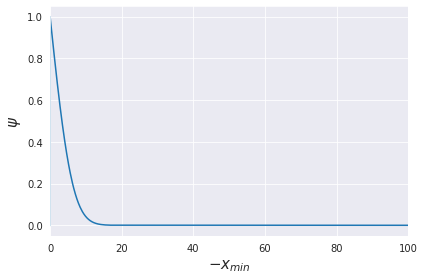

In [ ]:
# plot psi x_min
n_inf_x_min = liq_df2[~liq_df2['x_min'].isin([np.inf, -np.inf])].sort_values(by=['x_min'])
print(f"scale of x_min ({n_inf_x_min['x_min'].min()},{n_inf_x_min['x_min'].max()})")
plt.plot(list(-n_inf_x_min["x_min"]),list( n_inf_x_min["psi"]))
plt.xlabel(r'$-x_{min}$',size = 15)
plt.ylabel(r"$\psi$",size = 15)
# plt.grid(True)
plt.xlim((0,100))
plt.tight_layout()
plt.show()

In [ ]:
liq_df2.head()

usr fn_name  timestamp  \
0  0xc2CFFb94Aa21511D71bbC1A3709706cEA7D0F5eD    frob 2021-03-19   
1  0x0c0B8b5Bf239adBe4b80b6e66be9AA577E497dDB    fork 2019-11-19   
2  0x0c0B8b5Bf239adBe4b80b6e66be9AA577E497dDB    fork 2019-11-20   
3  0xf2dfd777d50bbF108Cb7e977Bc063E4A6bAf7Ba3    frob 2021-07-14   
4  0xf2dfd777d50bbF108Cb7e977Bc063E4A6bAf7Ba3    frob 2021-08-02   

           dart      dink_dai          dtab  wad           art           ink  \
0   3289.016182   9127.730971   3400.000000  NaN   3289.016182   9127.730971   
1  10320.268294  16871.358633  10327.046576  NaN  13969.165199  22836.567671   
2   1056.064209   1741.857305   1056.768596  NaN  18554.762148  30399.759876   
3   9520.766397  19437.900000  10000.000000  NaN   9520.766397  19437.900000   
4      0.000000   4966.562385      0.000000  NaN  14275.507941  24404.462385   

            tab      ex_rate      rate  collateral ratio     tab_at_mn  \
0   3400.000000  1825.546194  1.033744        268.462676   3400.108708   
1  13978.295917   173.775000  1.000657        163.371614  13978.370862   
2  18566.940504   175.321400  1.000667        163.730583  18568.843818   
3  10000.000000  1943.790000  1.050336        194.379000  10000.438864   
4  15000.000000  2612.700000  1.051582        162.696416  15000.563940   

       x_min           psi           var  
0 -29.498219  1.730533e-09  1.730533e-09  
1  -4.327380  3.770647e-01  2.348869e-01  
2  -4.438609  3.649243e-01  2.317545e-01  
3 -13.134305  7.339957e-03  7.286082e-03  
4  -4.117553  4.006339e-01  2.401264e-01

In [ ]:
vat_E.head()

fn_name    ilk                                         usr  \
0    frob  ETH-A  0x4D7770ce9679ac53C32760b52637195F4421C253   
1    frob  ETH-A  0x9fDc236BB08B80b5aB3D3bf7140b5068cC2EA88a   
2    frob  ETH-A  0x7097Bd26dB93B34c2E95112ABd75C00A1E5BDd9E   
3    frob  ETH-A  0xec76aEB63c0040D3C0AdF7990e43AB146B133606   
4    frob  ETH-A  0xDB47695103dc0a2645A25B8F11EA0a5c03FE52E8   

                                          src           timestamp  dart  dink  \
0  0x4D7770ce9679ac53C32760b52637195F4421C253 2019-11-13 21:22:33   0.0  0.00   
1  0x9fDc236BB08B80b5aB3D3bf7140b5068cC2EA88a 2019-11-13 21:45:03   0.0  0.10   
2  0x7097Bd26dB93B34c2E95112ABd75C00A1E5BDd9E 2019-11-13 22:07:52   0.0  0.10   
3  0xec76aEB63c0040D3C0AdF7990e43AB146B133606 2019-11-13 22:09:02   0.0  0.06   
4  0xDB47695103dc0a2645A25B8F11EA0a5c03FE52E8 2019-11-13 22:10:04   0.0  0.05   

   wad      rate        time_f  
0  NaN  1.000006  1.573680e+09  
1  NaN  1.000007  1.573682e+09  
2  NaN  1.000009  1.573683e+09  
3  NaN  1.000009  1.573683e+09  
4  NaN  1.000009  1.573683e+09

In [ ]:
daieth2.head()

timestamp  dai/eth   timestamp_f
0 2019-11-13 21:22:33   187.43  1.573680e+09
1 2019-11-13 21:45:03   186.70  1.573682e+09
2 2019-11-13 22:07:52   187.12  1.573683e+09
3 2019-11-13 22:09:02   186.66  1.573683e+09
4 2019-11-13 22:10:04   186.65  1.573683e+09

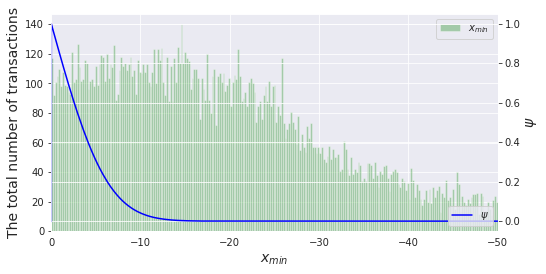

In [ ]:
fig, ax1 = plt.subplots(1,1,  figsize=(8,4) )
n_inf_x_min['x_min'].hist(ax=ax1, bins=10000, color='green',alpha = 0.3, label = r'$x_{min}$')
ax2 = ax1.twinx()
n_inf_x_min.plot.line(ax=ax2,x='x_min', y='psi', color='blue', label = r'$\psi$')
ax1.set_xlim((0,-50))
ax2.set_xlim((0,-50))

ax2.set_ylabel(r'$\psi$', fontsize=14) # from theory
ax1.set_ylabel(r'The total number of transactions', fontsize=14) # from actual data
ax1.set_xlabel(r'$x_{min}$', fontsize=14)
locs = ["upper right", "lower right"]
ax1.legend(loc=locs[0])
ax2.legend(loc=locs[1])
plt.show()

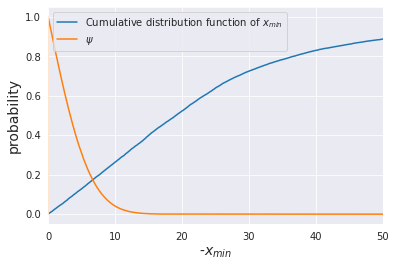

In [ ]:
#sort data
data=list(n_inf_x_min['x_min'])
data = [-x for x in data]
x = np.sort(data)

#calculate CDF values
y = 1. * np.arange(len(data)) / (len(data) - 1)

#plot CDF
plt.plot(x, y, label = r'Cumulative distribution function of $x_{min}$')
plt.plot(list(-n_inf_x_min["x_min"]),list( n_inf_x_min["psi"]), label = r'$\psi$')
plt.xlabel(r'$-x_{min}$',size = 14)
plt.ylabel("probability",size = 14)
plt.xlim(-0.01,50)
plt.xlabel(r'-$x_{min}$')
plt.legend()
plt.show()

In [ ]:
daieth2

timestamp      dai/eth   timestamp_f
0      2019-11-13 21:22:33   187.430000  1.573680e+09
1      2019-11-13 21:45:03   186.700000  1.573682e+09
2      2019-11-13 22:07:52   187.120000  1.573683e+09
3      2019-11-13 22:09:02   186.660000  1.573683e+09
4      2019-11-13 22:10:04   186.650000  1.573683e+09
...                    ...          ...           ...
300828 2023-03-31 15:56:11  1835.900000  1.680278e+09
300829 2023-03-31 15:57:59  1835.900000  1.680278e+09
300830 2023-03-31 16:23:11  1835.900000  1.680280e+09
300831 2023-03-31 20:49:59  1829.124161  1.680296e+09
300832 2023-03-31 23:05:23  1823.010480  1.680304e+09

[300833 rows x 3 columns]

In [ ]:
vat_E[vat_E.fn_name == 'grab'].drop(['ilk', 'usr','wad','src','dart','dink','rate'], axis=1)

fn_name           timestamp        time_f
233       grab 2019-11-18 17:15:23  1.574097e+09
338       grab 2019-11-18 17:56:05  1.574100e+09
446       grab 2019-11-18 19:07:03  1.574104e+09
448       grab 2019-11-18 19:07:33  1.574104e+09
545       grab 2019-11-18 20:07:42  1.574108e+09
...        ...                 ...           ...
538549    grab 2022-11-09 09:00:11  1.667984e+09
538758    grab 2022-11-09 23:00:11  1.668035e+09
539931    grab 2022-12-16 11:00:11  1.671188e+09
541713    grab 2023-03-03 21:00:11  1.677877e+09
542638    grab 2023-03-29 23:00:11  1.680131e+09

[6425 rows x 3 columns]

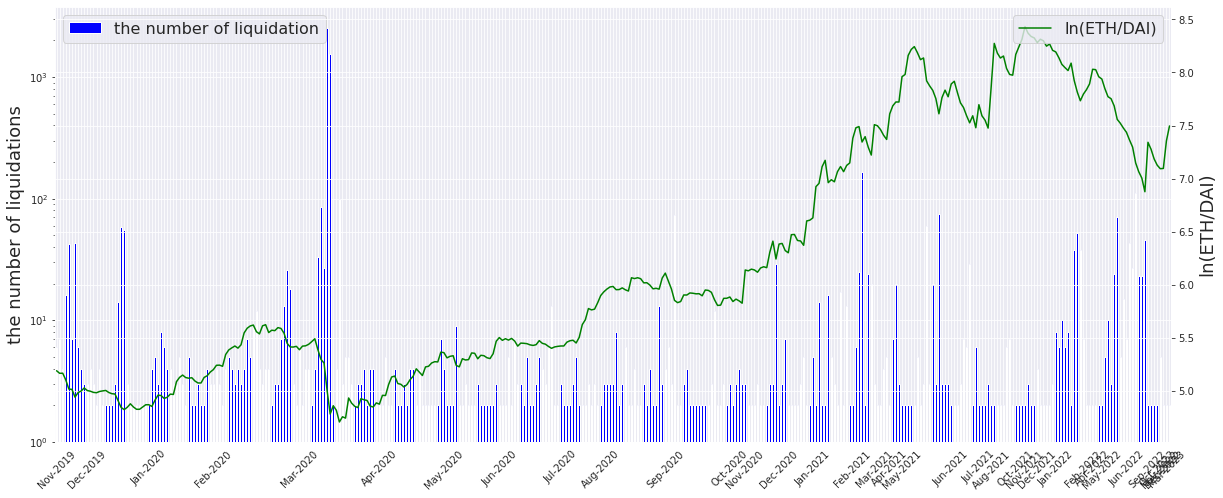

In [ ]:
# both y axis are in log
daieth_gp = daieth2.copy()
daieth_gp["timestamp"] = daieth_gp["timestamp"].astype("datetime64")
daieth_gp['dai/eth']= np.log(daieth_gp['dai/eth']) # TAKE log

a = vat_E[vat_E.fn_name == 'grab'].drop(['ilk', 'usr','wad','src','dart','dink','rate'], axis=1)
a.timestamp = a.timestamp.astype("datetime64")
a.timestamp = a.timestamp.dt.date
daieth_gp.timestamp = daieth_gp.timestamp.dt.date
daieth_gp_group = daieth_gp.groupby(['timestamp']).mean().reset_index(level=0)
b = a.groupby('timestamp').count().reset_index(level=['timestamp']).rename(columns={'fn_name': 'Count'})


merge_df = pd.merge(b, daieth_gp_group, on='timestamp', how='inner')
merge_df[merge_df['Count'] == merge_df['Count'].max()]

merge_df['M-Y-Date'] = pd.to_datetime(merge_df['timestamp'])
merge_df['M-Y-Date']= merge_df['M-Y-Date'].dt.to_period('M')

new = str()
list_date = []
for j in list(merge_df['M-Y-Date'] ):
    if j == new:
        list_date.append(" ")
    else:
        list_date.append(j.strftime('%b-%Y'))
    new = j

###################################################

fig, ax1 = plt.subplots(1,1,figsize=(20, 8))
merge_df['Count'].plot(ax=ax1, color='blue',kind='bar',log=True, label = 'the number of liquidation')
ax2 = ax1.twinx()
merge_df['dai/eth'].plot(ax=ax2, color='green', label = 'ln(ETH/DAI)')

ax1.set_ylabel('the number of liquidations', fontsize=18)
ax2.set_ylabel('ln(ETH/DAI)', fontsize=18)

list_date_replace = [sub.replace('Sep-2021', '').replace('Mar-2022','') for sub in list_date] # due to x label is overlapping
ax1.set_xticklabels(list_date_replace,rotation=45, fontsize=10)
ax2.set_xticklabels(list_date_replace,rotation=45, fontsize=10)

ax1.legend(loc="upper left", fontsize=16)
ax2.legend(loc="upper right", fontsize=16)
plt.show()


# Prediction

In [ ]:
vat_E[vat_E.fn_name == 'grab'].drop(['ilk', 'usr','wad','src','dart','dink','rate'], axis=1)

fn_name           timestamp        time_f
233       grab 2019-11-18 17:15:23  1.574097e+09
338       grab 2019-11-18 17:56:05  1.574100e+09
446       grab 2019-11-18 19:07:03  1.574104e+09
448       grab 2019-11-18 19:07:33  1.574104e+09
545       grab 2019-11-18 20:07:42  1.574108e+09
...        ...                 ...           ...
538549    grab 2022-11-09 09:00:11  1.667984e+09
538758    grab 2022-11-09 23:00:11  1.668035e+09
539931    grab 2022-12-16 11:00:11  1.671188e+09
541713    grab 2023-03-03 21:00:11  1.677877e+09
542638    grab 2023-03-29 23:00:11  1.680131e+09

[6425 rows x 3 columns]

In [ ]:
n_inf_x_min[n_inf_x_min.fn_name == 'grab'].drop(['dart', 'dink_dai','dtab','wad','art','ink','tab', 'ex_rate', 'rate', "collateral ratio", 'tab_at_mn', 'x_min', 'psi', 'var'], axis=1)

usr fn_name  timestamp
105  0x7d5EB0658f8F55AEeaF2ec949aE5C9572A9dc6f3    grab 2020-09-05

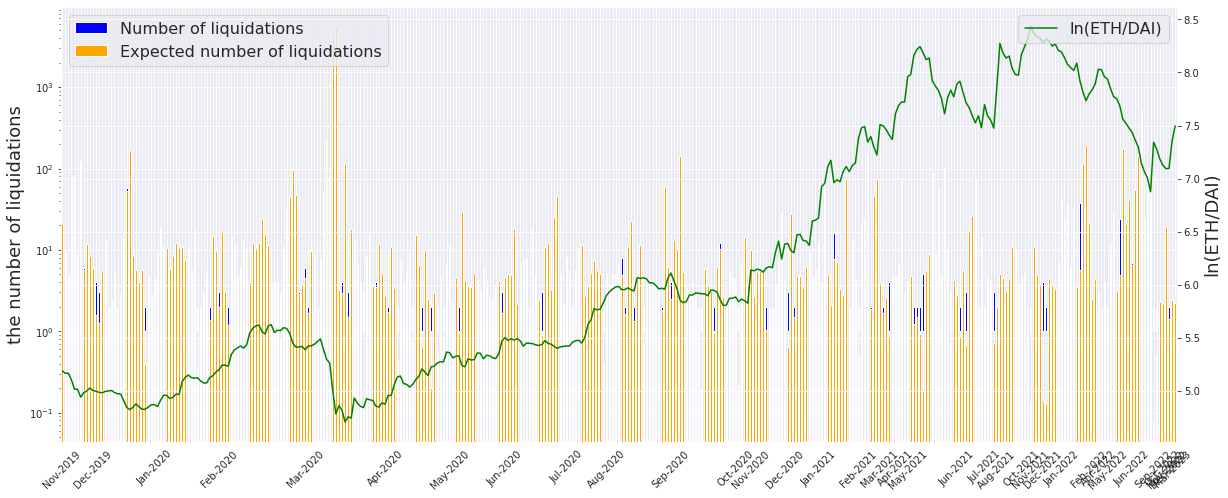

In [ ]:
# both y axis are in log
daieth_gp = daieth2.copy()
daieth_gp["timestamp"] = daieth_gp["timestamp"].astype("datetime64")
daieth_gp['dai/eth']= np.log(daieth_gp['dai/eth']) # TAKE log

a = vat_E[vat_E.fn_name == 'grab'].drop(['ilk', 'usr','wad','src','dart','dink','rate'], axis=1)
a.timestamp = a.timestamp.astype("datetime64")
a.timestamp = a.timestamp.dt.date
daieth_gp.timestamp = daieth_gp.timestamp.dt.date
daieth_gp_group = daieth_gp.groupby(['timestamp']).mean().reset_index(level=0)
b = a.groupby('timestamp').count().reset_index(level=['timestamp']).rename(columns={'fn_name': 'Count'})


merge_df = pd.merge(b, daieth_gp_group, on='timestamp', how='inner')
merge_df[merge_df['Count'] == merge_df['Count'].max()]

merge_df['M-Y-Date'] = pd.to_datetime(merge_df['timestamp'])
merge_df['M-Y-Date']= merge_df['M-Y-Date'].dt.to_period('M')

new = str()
list_date = []
for j in list(merge_df['M-Y-Date'] ):
    if j == new:
        list_date.append(" ")
    else:
        list_date.append(j.strftime('%b-%Y'))
    new = j

###################################################

fig, ax1 = plt.subplots(1,1,figsize=(20, 8))
merge_df['Count'].plot(ax=ax1, color='blue',kind='bar',log=True, label = 'Number of liquidations')

merge_df['Count_pred'].plot(ax=ax1, color='orange',kind='bar',log=True, label = 'Expected number of liquidations')
ax2 = ax1.twinx()
merge_df['dai/eth'].plot(ax=ax2, color='green', label = 'ln(ETH/DAI)')

ax1.set_ylabel('the number of liquidations', fontsize=18)
ax2.set_ylabel('ln(ETH/DAI)', fontsize=18)

list_date_replace = [sub.replace('Sep-2021', '').replace('Mar-2022','') for sub in list_date] # due to x label is overlapping
ax1.set_xticklabels(list_date_replace,rotation=45, fontsize=10)
ax2.set_xticklabels(list_date_replace,rotation=45, fontsize=10)

ax1.legend(loc="upper left", fontsize=16)
ax2.legend(loc="upper right", fontsize=16)

plt.savefig('/mnt/SSD/mikhail.evdokimov/datasets/CourseWork/poisson.png')

plt.show()


In [ ]:
from scipy.special import rel_entr

sum(rel_entr(merge_df['Count'].to_list() ,merge_df['Count_pred'].to_list()))

-3068.674237669988

In [ ]:
def kl_divergence(p, q):
    p = np.asarray(p, dtype=np.float)
    q = np.asarray(q, dtype=np.float)
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

p = merge_df['Count'].to_list()
q = merge_df['Count_pred'].to_list()

kl_div = kl_divergence(q, p)
print("KL divergence between p and q:", kl_div)

KL divergence between p and q: -618.398861693689


In [ ]:
import numpy as np

def total_variation(p, q):
    p = np.asarray(p, dtype=np.float)
    q = np.asarray(q, dtype=np.float)
    return 0.5 * np.sum(np.abs(p - q))

tv = total_variation(p, q)
print("Total variation between p and q:", tv)

Total variation between p and q: 1126.2764859354659


In [ ]:
def calculate_mse(list1, list2):
    mse = np.mean((np.array(list1) - np.array(list2))**2)
    return mse

def calculate_mae(list1, list2):
    mae = np.mean(np.abs(np.array(list1) - np.array(list2)))
    return mae

mse = calculate_mse(p, q)
mae = calculate_mae(p, q)

print("MSE: ", mse)
print("MAE: ", mae)

MSE:  2840.9740384779707
MAE:  6.20538008779871


In [ ]:
# Augmented Dickey-Fuller test. Test for unit root
from statsmodels.tsa.stattools import adfuller

# perform the ADF test on the real data column
result_real = adfuller(merge_df['Count'])

# perform the ADF test on the predicted data column
result_predicted = adfuller(merge_df['Count_pred'])

# print the ADF test results for the real data
print('ADF Statistic for real data: %f' % result_real[0])
print('p-value for real data: %f' % result_real[1])
print('Critical Values for real data:')
for key, value in result_real[4].items():
    print('\t%s: %.3f' % (key, value))

# print the ADF test results for the predicted data
print('ADF Statistic for predicted data: %f' % result_predicted[0])
print('p-value for predicted data: %f' % result_predicted[1])
print('Critical Values for predicted data:')
for key, value in result_predicted[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic for real data: -8.899384
p-value for real data: 0.000000
Critical Values for real data:
	1%: -3.449
	5%: -2.870
	10%: -2.571
ADF Statistic for predicted data: -8.986386
p-value for predicted data: 0.000000
Critical Values for predicted data:
	1%: -3.449
	5%: -2.870
	10%: -2.571


The ADF test statistic is a negative number, and the more negative it is, the stronger the evidence against the null hypothesis (that the series has a unit root) and in favor of the alternative hypothesis (that the series is stationary). If the p-value is less than a chosen significance level (e.g., 0.05), then we can reject the null hypothesis and conclude that the series is stationary. The critical values are used to determine the significance level at which the null hypothesis can be rejected. If the ADF statistic is less than the critical value at the chosen significance level, then we can reject the null hypothesis.

In [ ]:
import pandas as pd
from scipy.stats import ttest_ind

# using t-test
t_statistic, p_value = ttest_ind(merge_df['Count'], merge_df['Count_pred'])

# result
print('T-statistic: {:.2f}'.format(t_statistic))
print('P-value: {:.3f}'.format(p_value))
if p_value < 0.05:
    print('Statistically significant differences between samples')
else:
    print('The samples do not differ statistically significantly')

T-statistic: 0.31
P-value: 0.755
The samples do not differ statistically significantly


# Expected poission

KeyError: 'Count_pred'

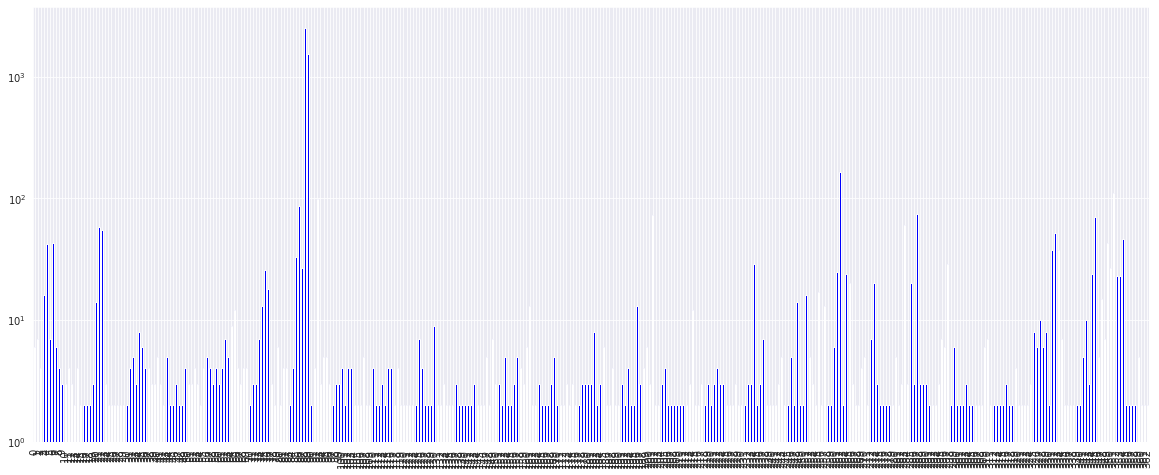

In [ ]:
# both y axis are in log
daieth_gp = daieth2.copy()
daieth_gp["timestamp"] = daieth_gp["timestamp"].astype("datetime64")
daieth_gp['dai/eth']= np.log(daieth_gp['dai/eth']) # TAKE log

a = vat_E[vat_E.fn_name == 'grab'].drop(['ilk', 'usr','wad','src','dart','dink','rate'], axis=1)
a.timestamp = a.timestamp.astype("datetime64")
a.timestamp = a.timestamp.dt.date
daieth_gp.timestamp = daieth_gp.timestamp.dt.date
daieth_gp_group = daieth_gp.groupby(['timestamp']).mean().reset_index(level=0)
b = a.groupby('timestamp').count().reset_index(level=['timestamp']).rename(columns={'fn_name': 'Count'})


merge_df = pd.merge(b, daieth_gp_group, on='timestamp', how='inner')
merge_df[merge_df['Count'] == merge_df['Count'].max()]

merge_df['M-Y-Date'] = pd.to_datetime(merge_df['timestamp'])
merge_df['M-Y-Date']= merge_df['M-Y-Date'].dt.to_period('M')

new = str()
list_date = []
for j in list(merge_df['M-Y-Date'] ):
    if j == new:
        list_date.append(" ")
    else:
        list_date.append(j.strftime('%b-%Y'))
    new = j

###################################################

fig, ax1 = plt.subplots(1,1,figsize=(20, 8))
merge_df['Count'].plot(ax=ax1, color='blue',kind='bar',log=True, label = 'Number of liquidations')
merge_df['Count_pred'].plot(ax=ax1, color='orange',kind='bar',log=True, label = 'Expected number of liquidations')
ax2 = ax1.twinx()
merge_df['dai/eth'].plot(ax=ax2, color='green', label = 'ln(ETH/DAI)')

ax1.set_ylabel('the number of liquidations', fontsize=18)
ax2.set_ylabel('ln(ETH/DAI)', fontsize=18)

list_date_replace = [sub.replace('Sep-2021', '').replace('Mar-2022','') for sub in list_date] # due to x label is overlapping
ax1.set_xticklabels(list_date_replace,rotation=45, fontsize=10)
ax2.set_xticklabels(list_date_replace,rotation=45, fontsize=10)

ax1.legend(loc="upper left", fontsize=16)
ax2.legend(loc="upper right", fontsize=16)
plt.show()


In [ ]:
from scipy.stats import poisson
avg = np.mean(merge_df['Count'])
probs = [poisson.pmf(i, avg) for i in range(len(merge_df['Count']))]
for i in range(len(merge_df['Count']):
    print(f"Probability of {i} match score: {match_probs[i,j]:.3f}")

In [ ]:
abs(liq_df2.timestamp.min()-liq_df2.timestamp.max()).days

In [ ]:
df_count = liq_df2.groupby(by=liq_df2['timestamp']).size().reset_index(name='counts').sort_values(by='timestamp')

In [ ]:
df_count

# Optimization

objective function: $$  \|\vec{a}\|_1 \rightarrow max \,\, \vec{a}$$

constraints:
$$
\begin{gathered}
\vec{a}^{T} K \vec{a} \leq \sigma^{2} \cdot\|\vec{a}\|_{1}^{2} \\
\overrightarrow{0} \leq \vec{a} \leq \vec{A}
\end{gathered}
$$

In [ ]:
# ---------- read all data ----------
# vat_E
vat_E = pd.read_csv(my_global_path + '/vat_E.csv').drop(columns=['Unnamed: 0'])
vat_E['timestamp'] = vat_E['timestamp'].astype({ 'timestamp': 'datetime64' })

# ETH/DAI rate
daieth2 = pd.read_csv(my_global_path + '/daieth2.csv').drop(columns=['Unnamed: 0'])
daieth2['timestamp'] = daieth2['timestamp'].astype({ 'timestamp': 'datetime64' })

# stability fee rate
sf_rate_pd = pd.read_csv(my_global_path + '/sf_rate_pd.csv').drop(columns=['Unnamed: 0'])
sf_rate_pd['timestamp'] = sf_rate_pd['timestamp'].astype({ 'timestamp': 'datetime64' })

# see shape
print(f'vat_E shape = {vat_E.shape} \ndaieth2 shape = {daieth2.shape} \nsf_rate_pd shape = {sf_rate_pd.shape}')

# group grab users
ethA = vat_E.copy()
ethA_default = filter_ethA_data(vat_E)
grouped = ethA_default.groupby('usr')
grab = ethA[ethA['fn_name'] == 'grab']
grab_usr = set(grab.groupby('usr').groups.keys())

# liq_df2
liq_df2 = pd.read_csv(my_global_path + '/liq_df2.csv').drop(columns=['Unnamed: 0'])
liq_df2['timestamp'] = liq_df2['timestamp'].astype({ 'timestamp': 'datetime64' })

# df_count
df_count = liq_df2.groupby(by=liq_df2['timestamp']).size().reset_index(name='counts').sort_values(by='timestamp')

# see liq_df2
liq_df2.head(2)

In [ ]:
# from Forex data
sigma2 = 0.00198/1.27
sigma = np.sqrt(sigma2)

# All timestamps
duration_date = sorted(list(liq_df2['timestamp'].unique()))

print(f'All days = {len(duration_date)} \nfrom {min(duration_date)} to {max(duration_date)}')

## SOCP

Find nearest SPD ([link](https://www.mathworks.com/matlabcentral/fileexchange/42885-nearestspd))

In [ ]:
len(duration_date)

In [ ]:
mtx_K = {}
for ii, day_idx in tqdm(enumerate(sorted(duration_date))):
    table = liq_df2[liq_df2["timestamp"] == day_idx]
    A = np.array(table['tab_at_mn'])
    K = np.zeros((table.shape[0], table.shape[0]))
    for i,(p_A,x_A) in enumerate(zip(list(table['psi']),list(table['x_min']))):
        for j,(p_B,x_B) in enumerate(zip(list(table['psi']),list(table['x_min']))):
            K[i,j] = p_B * (1 - p_A) if x_A > x_B else p_A * (1 - p_B)
    mtx_K[day_idx] = K

In [ ]:
mtx_K[duration_date[9]]

In [ ]:
# pd_L = {}
spd_K = {}
for date, K in mtx_K.items():
    try:
        L = np.linalg.cholesky(K)
        # pd_L[date] = L
    except:
        spd_K[date] = K

In [ ]:
len(spd_K)

In [ ]:
spd_date = []
for date, K in spd_K.items():
    spd_date.append(date)
len(spd_date)



---



In [ ]:
day_idx = duration_date[5]
mtx = mtx_K[day_idx]
lmbd, U = np.linalg.eig(mtx)
lmbd

In [ ]:
diag_lmbd = np.sqrt(np.diag(np.round(lmbd, 16)))
diag_lmbd[1]

In [ ]:
U_lamb = np.dot(U, diag_lmbd)
vec = np.dot(U_lamb, U_lamb.T)
mat_mul = U_lamb @ U_lamb.T
print(np.linalg.norm(mtx-vec, ord='fro'), np.linalg.norm(mtx-mat_mul, ord='fro') )

In [ ]:
# table = liq_df2[liq_df2["timestamp"] == day_idx]
table = liq_df2[liq_df2["psi"] < 0]
table[['timestamp', 'psi', 'x_min']]

In [ ]:
table = liq_df2[((liq_df2["x_min"] < 0) & (liq_df2["psi"] < 0))]
table[['timestamp', 'psi', 'x_min']]



---



In [ ]:
norm_control = []
all_L = []
for ii, day_idx in tqdm(enumerate(sorted(duration_date))):
    table = liq_df2[liq_df2["timestamp"] == day_idx]
    A = np.array(table['tab_at_mn'])
    K = np.zeros((table.shape[0], table.shape[0]))
    for i, (p_A, x_A) in enumerate(zip(list(table['psi']), list(table['x_min']))):
        for j, (p_B, x_B) in enumerate(zip(list(table['psi']), list(table['x_min']))):
            K[i, j] = p_B * (1 - p_A) if x_A > x_B else p_A * (1 - p_B)

    # symmetric
    K = 1/2 * (K + K.T)

    # Adjust K if K isn't PD
    try:
        L = np.linalg.cholesky(K)
    except:
        lmbd, U = np.linalg.eig(K)
        diag_lmbd = np.sqrt(np.diag(np.round(lmbd, 16)))
        L = np.dot(U, diag_lmbd)
        vec = np.dot(L, L.T)
        mat_mul = L @ L.T
        norm_control.append((np.linalg.norm(K - vec, ord='fro'), np.linalg.norm(K - mat_mul, ord='fro')))
    all_L.append(L)

In [ ]:
len(norm_control)

In [ ]:
def margine(vector_a, sigma2, covariance_matrix):
    return sigma2 * np.linalg.norm((vector_a), ord=1)**2 - ((vector_a @ covariance_matrix) @ vector_a)

def ub_constraint(vector_a, A):
    return cp.sum(vector_a) - cp.sum(A)

def validate_positive_definitive(M):
    M = (M + M.T) * 0.5
    k = 0
    I = np.eye(M.shape[0])
    while True:
        try:
            _ = np.linalg.cholesky(M)
            break
        except np.linalg.LinAlgError:
            k += 1
            w, v = np.linalg.eig(M)
            min_eig = v.min()

            if isinstance(min_eig, complex):
              min_eig = float(min_eig)
              M += (-min_eig * k * k + np.spacing(min_eig)) * I
              return (M, -v.min(), v.max(), -v.min()/v.max())
            else:
              M += (-min_eig * k * k + np.spacing(min_eig)) * I
              return (M, -v.min(), v.max(), -v.min()/v.max())


In [ ]:
K_not_pos_def = []
validate_to_pd = []

for ii, day_idx in tqdm(enumerate(sorted(duration_date))):
    table = liq_df2[liq_df2["timestamp"] == day_idx]
    A = np.array(table['tab_at_mn'])
    K = np.zeros((table.shape[0], table.shape[0]))
    for i,(p_A,x_A) in enumerate(zip(list(table['psi']),list(table['x_min']))):
        for j,(p_B,x_B) in enumerate(zip(list(table['psi']),list(table['x_min']))):
            K[i,j] = p_B * (1-p_A) if x_A > x_B else p_A * (1-p_B)

    # symmetric
    K = 1/2*(K + K.T)

    # Adjust K if K isn't PD
    try:
        L = np.linalg.cholesky(K)
    except:
        (K, mi_v_min, v_max, mi_v_min_max) = validate_positive_definitive(K)
        try:
            L = np.linalg.cholesky(K)
        except:
            K_not_pos_def.append(K)
            validate_to_pd.append(day_idx)
            continue



In [ ]:
len(K_not_pos_def)

In [ ]:
len(validate_to_pd)

In [ ]:
validate_to_pd

## optimization

In [ ]:
tokenized_volume_meta = []
margines = []
tokenizations = []
frac_tokenizations = []
vol_A_meta = []
vol_sum_A = []

data_vminmax = []
K_validate = []
K_real = []
validate_to_pd = []
val_timess = 0

date_prob = []

norm_control = []

global K_not_pos_def
K_not_pos_def = []

for ii, day_idx in tqdm(enumerate(sorted(duration_date))):
    table = liq_df2[liq_df2["timestamp"] == day_idx]
    A = np.array(table['tab_at_mn'])
    K = np.zeros((table.shape[0], table.shape[0]))
    for i,(p_A,x_A) in enumerate(zip(list(table['psi']),list(table['x_min']))):
        for j,(p_B,x_B) in enumerate(zip(list(table['psi']),list(table['x_min']))):
            K[i,j] = p_B * (1-p_A) if x_A > x_B else p_A * (1-p_B)

    # symmetric
    K = 1/2*(K + K.T)

    # Adjust K if K isn't PD
    try:
        L = np.linalg.cholesky(K)
    except:
        lmbd, U = np.linalg.eig(K)
        diag_lmbd = np.sqrt(np.diag(np.round(lmbd, 16)))
        L = np.dot(U, diag_lmbd)
        vec = np.dot(U_lamb, U_lamb.T)
        mat_mul = U_lamb @ U_lamb.T
        norm_control.append((np.linalg.norm(mtx-vec, ord='fro'), np.linalg.norm(mtx-mat_mul, ord='fro')))

    a = cp.Variable(K.shape[0])
    f_t = np.ones(K.shape[0])

    # We use cp.SOC(t, x) to create the SOC constraint ||x||_2 <= t.
    soc_constraints = [cp.SOC( sigma * (f_t.T @ a), L.T @ a )]

    prob = cp.Problem(cp.Minimize(-(f_t.T @ a)), soc_constraints + [a>=0] + [a <= A] )

    prob.solve()

    tokenized_volume_meta.append(np.sum(a.value))
    margines.append(margine(a.value, sigma2, K))
    tokenizations.append(a.value)
    vol_A_meta.append(A)
    frac = np.sum(a.value)/ np.sum(A)
    frac_tokenizations.append(frac)
    vol_sum_A.append(np.sum(A))


In [ ]:
# tokenized_volume_meta = []
# margines = []
# tokenizations = []
# frac_tokenizations = []
# vol_A_meta = []
# vol_sum_A = []

# data_vminmax = []
# K_validate = []
# K_real = []
# validate_to_pd = []
# val_timess = 0

# date_prob = []

# global K_not_pos_def
# K_not_pos_def = []

# for ii, day_idx in tqdm(enumerate(sorted(duration_date))):
#     table = liq_df2[liq_df2["timestamp"] == day_idx]
#     A = np.array(table['tab_at_mn'])
#     K = np.zeros((table.shape[0], table.shape[0]))
#     for i,(p_A,x_A) in enumerate(zip(list(table['psi']),list(table['x_min']))):
#         for j,(p_B,x_B) in enumerate(zip(list(table['psi']),list(table['x_min']))):
#             K[i,j] = p_B * (1-p_A) if x_A > x_B else p_A * (1-p_B)

#     # symmetric
#     K = 1/2*(K + K.T)

#     # Adjust K if K isn't PD
#     try:
#         L = np.linalg.cholesky(K)
#     except:
#         K_real.append(K)

#         (K, mi_v_min, v_max, mi_v_min_max) = validate_positive_definitive(K)
#         K_validate.append(K)
#         try:
#             L = np.linalg.cholesky(K)
#         except:
#             K_not_pos_def.append(K)
#             continue
#         validate_to_pd.append(day_idx)
#         data_vminmax.append([day_idx, mi_v_min, v_max, mi_v_min_max])
#         val_timess += 1

#     a = cp.Variable(K.shape[0])
#     f_t = np.ones(K.shape[0])

#     # We use cp.SOC(t, x) to create the SOC constraint ||x||_2 <= t.
#     soc_constraints = [cp.SOC( sigma * (f_t.T @ a), L.T @ a )]

#     prob = cp.Problem(cp.Minimize(-(f_t.T @ a)), soc_constraints + [a>=0] + [a <= A] )

#     prob.solve()

#     tokenized_volume_meta.append(np.sum(a.value))
#     margines.append(margine(a.value, sigma2, K))
#     tokenizations.append(a.value)
#     vol_A_meta.append(A)
#     frac = np.sum(a.value)/ np.sum(A)
#     frac_tokenizations.append(frac)
#     vol_sum_A.append(np.sum(A))


## problems

In [ ]:
len(K_not_pos_def)

In [ ]:
print(len(K_real))
len(K_real) == len(date_prob)

In [ ]:
all_K = {}

for ii, day_idx in tqdm(enumerate(sorted(duration_date))):
    table = liq_df2[liq_df2["timestamp"] == day_idx]
    A = np.array(table['tab_at_mn'])
    K = np.zeros((table.shape[0], table.shape[0]))
    for i,(p_A,x_A) in enumerate(zip(list(table['psi']),list(table['x_min']))):
        for j,(p_B,x_B) in enumerate(zip(list(table['psi']),list(table['x_min']))):
            K[i,j] = p_B * (1-p_A) if x_A > x_B else p_A * (1-p_B)

    all_K[str(day_idx)[:10]] = K

In [ ]:
print(date_prob[0])
test_k = K_real[0]
test_k.shape

In [ ]:
test_k

In [ ]:
kk = np.round(test_k, 8)
kk[0][0]

In [ ]:
np.linalg.cholesky(kk)

In [ ]:
a, b = np.linalg.eig(kk)
print(a)

In [ ]:
np.float16(a[0])

# From Industrial Immersion

## Discrete

In [ ]:
class Discrete:
    def __init__(self, A0, N0, k0):
        self.A = A0.astype(int) # array of assets
        self.N = N0 # number of assets types
        self.k = k0 # number of assets in each package


    def preprocess(self):
        assert self.N == len(self.A), "Wrong N"
        assert self.k <= len(self.A), "Wrong k"
        self.A = self.A * self.k
        sort_indexes = np.argsort(self.A, axis=None)
        self.inverse_sort_indexes = np.empty_like(sort_indexes)
        self.inverse_sort_indexes[sort_indexes] = np.arange(sort_indexes.size)
        A = self.A[sort_indexes]
        a = np.sort(self.A, axis=None) # min-max sorting
        largest_ele_index = heapq.nlargest(self.k-1, range(len(a)))
        S = 0
        for i in range(0, len(a)):
            if i not in largest_ele_index:
                S = S + np.sum(a[i]) # sum of all token except biggest k-1 types
        B = 0
        n = 2
        a_res = a
        for start in range(self.N - self.k+1,self.N): # a_{N-k+n} = min[A_{N-k+n}, S/(n-1)] to remove some tokens
            index_S_inner = self.N-self.k+n-1
            S_inner = np.sum(a[0:index_S_inner])
            if math.floor(S_inner/(n-1)) >= A[self.N-self.k+n-1]:
                a_res[self.N-self.k+n-1] = A[self.N-self.k+n-1]
                S = S + a_res[index_S_inner]
            else:
                a_res[self.N-self.k+n-1] = math.floor(S_inner/(n-1))
                S = S + a_res[index_S_inner]
            assert a_res[self.N-self.k+n-1] == min(A[self.N-self.k+n-1],math.floor(S_inner/(n-1)))
            delta = A[index_S_inner] - a_res[index_S_inner]
            B = B + delta # total number of tokens put off from packages
            n = n+1
        return a_res, B


    def distribution(self, a_res, B, return_distribution_matrix=False):
        S = np.sum(a_res)
        M = math.floor(S/self.k)
        B0 = abs(S - M*self.k) # number of token that isn't falling into packages due to multiplicity of S
        n = self.N - B0 +1
        for n in range(n, self.N+1):
            a_res[n-1] = a_res[n-1] - 1 # remove 1 tokens from last token's types
            B = B + B0
        l_n = np.zeros(self.N+1)
        r_n = np.zeros(self.N+1)
        for n in range(1,self.N+1):
            l_n[n] = np.sum(a_res[0:n-1])+1
            r_n[n] = np.sum(a_res[0:n])
        if return_distribution_matrix: # unique composition of each package as much as possible
            C_M = np.zeros((self.k, M))
            n = 1
            for i in range(1, M + 1):
                for j in range(1, self.k+1):
                    check_index = i + M * (j - 1)
                    for n in range(1, self.N+1):
                        if check_index <= r_n[n] and check_index >= l_n[n]:
                            C_M[j-1, i-1] = self.inverse_sort_indexes[n-1] + 1
                        n =n+1
            return a_res[self.inverse_sort_indexes]/self.k, M, C_M
        else:
            return a_res[self.inverse_sort_indexes]/self.k, M

In [ ]:
df_count = liq_df2.groupby(by=liq_df2['timestamp']).size().reset_index(name='counts').sort_values(by='timestamp')
tokenizations_d = []
tokenized_volume_d = []
vol_A_d = []
for ii, day_idx in tqdm(enumerate(sorted(list(liq_df2['timestamp'].unique())))):
        k = 10 #k = df_count['counts'].iloc[ii]
        table = liq_df2[liq_df2["timestamp"] == day_idx]
        A = np.array(table['tab_at_mn'])
        N = A.shape[0]
        if df_count['counts'].iloc[ii] >= k:
          res_discrete = Discrete(A, N, k)
          res_1, B = res_discrete.preprocess()
          a_res, _ = res_discrete.distribution(res_1, B)
        else:
          a_res = 0
        tokenizations_d.append(a_res)
        vol_A_d.append(A.sum())
        tokenized_volume_d.append(np.sum(a_res))
data_to_plot_discrete = [tokenized_volume_d[x] / vol_A_d[x] for x in range(len(tokenized_volume_d))]
volumes_array = np.array(vol_A_d)
print("Tokenized fraction: ", np.sum(tokenized_volume_d) / np.sum(volumes_array))

## Continuous

In [ ]:
from sympy import symbols, solve, Eq
import numpy as geek

class Continuous:
    def __init__(self, N0, A0, var_reduc):
        self.A = A0
        self.N = N0
        self.var = var_reduc

    def search(self):
        N = self.N
        assert self.N == len(self.A), "Wrong N"
        var = self.var
        E = np.array([0],dtype='float64') # expectation of taken assets
        V = np.array([0],dtype='float64') # varaince of taken assets
        a = np.zeros(self.N)
        sort_indexes = np.argsort(self.A, axis=None)
        self.inverse_sort_indexes = np.empty_like(sort_indexes)
        self.inverse_sort_indexes[sort_indexes] = np.arange(sort_indexes.size)
        A = self.A[sort_indexes]
        A = np.insert(A, 0, 0)
        for n in range(0, N): # replace a_k from A_n with A_{n+1}
            E_new = E + (N-n)*(A[n+1] - A[n])
            V_new = V + (N-n)*(A[n+1]**2 - A[n]**2)
            if (1 / var) * (E_new)**2 >= V_new:
                E = E_new
                V = V_new
                for k in range(n, N):
                    a[k] = A[n+1]
            else:
                x = symbols('x')
                eq = (1 / var)*(E + (N - n)*(x - A[n]))**2 - V - (N - n) * (x**2 - A[n]**2)
                A_sol = solve(eq)
                if len(A_sol) == 0:
                    A_sol = min(A)
                elif len(A_sol) == 1:
                    ################################################################################################################
                    print(A_sol[0])
                    B = A_sol[0]
                    # if A_sol == [{x: 0.0}] or list(A_sol.values())[0].is_extended_real == False:
                    if A_sol == [{x: 0.0}] or list(A_sol[0].values()).is_extended_real == False:
                        A_sol = min(A)
                    else:
                        A_sol = min(list(A_sol.values())[0], A[n + 1])
                elif len(A_sol) == 2:
                    if list(A_sol[1].values())[0].is_extended_real == False:
                        A_sol = min(A)
                    else:
                        A_sol = min(list(A_sol[1].values())[0], A[n + 1])
                E = E + (N-n)*(A_sol - A[n])
                V = V + (N-n)*(A_sol**2 - A[n]**2)
                n_star = n + 1
                for k in range(n_star-1, N):
                    a[k] = A_sol
        return a[self.inverse_sort_indexes]

    def construct_pack(self, a):
        M = np.linalg.norm((a), ord=1) # number of packages
        C_M  = a/M # composition of each M packages
        return  a[self.inverse_sort_indexes], M, C_M

In [ ]:
# global list_K
list_K = []

# Tokenized volume by using
vol_A_c = []
a_star_conti = []
tokenized_volume_cc = []
package_variance = []
for ii, day_idx in tqdm(enumerate(sorted(list(liq_df2['timestamp'].unique()))[0:])):
        k=df_count['counts'].iloc[ii]
        table = liq_df2[liq_df2["timestamp"] == day_idx]
        A = np.array(table['tab_at_mn'])
        N = A.shape[0]
        K = np.zeros((table.shape[0], table.shape[0]))

        for i,(p_A,x_A) in enumerate(zip(list(table['psi']),list(table['x_min']))):
            for j,(p_B,x_B) in enumerate(zip(list(table['psi']),list(table['x_min']))):
                K[i,j] = p_B * (1-p_A) if x_A > x_B else p_A * (1-p_B)
        list_K.append(K)

        res_conti = Continuous(N, A, k)
        res_1 = res_conti.search()
        a, _, C_M = res_conti.construct_pack(res_1)
        vol_A_c.append(A.sum())
        tokenized_volume_cc.append(np.sum(res_1))
        package_variance.append(np.matmul(np.matmul(C_M, K), C_M))
        a_star_conti.append(a)
data_to_plot_continuous = [tokenized_volume_cc[x] / vol_A_c[x] for x in range(len(tokenized_volume_cc))]
volumes_array = np.array(vol_A_c)
print("Tokenized fraction: ", np.sum(tokenized_volume_cc) / np.sum(volumes_array))


In [ ]:
A_sol = [{'x': 0}]
list(A_sol.values())[0]

In [ ]:
list(A_sol.index()).is_extended_real

In [ ]:
list(A_sol[0].values())

In [ ]:
# compact conti and conti alg

tokenized_volume_mcc = []
for i in tqdm(range(len(np.array(vol_A_c)))):
  res = max(np.array(tokenized_volume_cc)[i],np.array(tokenized_volume_meta)[i])
  tokenized_volume_mcc.append(res)
data_to_plot_mcc = [tokenized_volume_mcc[x] / vol_A_c[x] for x in range(len(tokenized_volume_cc))]
print(f'check conti and compact conti vol is the same {(np.array(vol_A_c) == np.array(vol_sum_A)).all()}\n')
print("Tokenized fraction: ", np.sum(tokenized_volume_mcc) / np.sum(vol_sum_A))


## Plot

In [ ]:
# look specifically at the straight horizontal line
# it seems like it is struck at ~ 321
tokenizations_sum_meta = [np.sum(a) for a in tokenizations]
day_idx = [idx for idx, x in enumerate(tokenizations_sum_meta) if x > 319 and x < 322]

tokenizations[day_idx[26]] , vol_A_meta[day_idx[26]]

In [ ]:
fig, axs = plt.subplots(2, 2,figsize=(15,10))
sort_indexes_mcc = np.argsort(np.array(vol_A_c))
axs[0, 0].plot(np.array(vol_A_c)[sort_indexes_mcc],label = "initial assets", color = 'k')
axs[0, 0].plot(np.array(tokenized_volume_mcc)[sort_indexes_mcc], label = "tokenized assets", alpha=1, linewidth=1, color = 'purple')
axs[0, 0].set_title('Compact continuous with continuous algorithm')

sort_indexes_d = np.argsort(np.array(vol_A_d))
axs[0, 1].plot(np.array(vol_A_d)[sort_indexes_d],label = "initial assets ", color = 'k')
axs[0, 1].plot(np.array(tokenized_volume_d )[sort_indexes_d], label = "tokenized assets", alpha=0.8, linewidth=1, color = 'g')
axs[0, 1].set_title('Discrete algorithm')

sort_indexes_cc = np.argsort(np.array(vol_A_c))
axs[1, 0].plot(np.array(vol_A_c)[sort_indexes_cc],label = "initial assets", color = 'k')
axs[1, 0].plot(np.array(tokenized_volume_cc)[sort_indexes_cc], label = "tokenized assets", alpha=1, linewidth=1, color = 'b')
axs[1, 0].set_title('Continuous algorithm')

sort_indexes_meta = np.argsort(np.array(vol_sum_A))
axs[1, 1].plot(np.array(vol_sum_A)[sort_indexes_meta][1:],label = "initial assets", color = 'k')
axs[1, 1].plot(np.array(tokenized_volume_meta)[sort_indexes_meta][1:] , label = "tokenized assets", alpha=0.8, linewidth=1,color = 'r')
axs[1, 1].set_title('Compact continuous algorithm')


for ax in axs.flat:
    ax.set(xlabel='Date index', ylabel='Outstanding debt' )
    ax.label_outer()
    ax.set_yscale('log')
    ax.legend()
    ax.title.set_size(15)
    ax.xaxis.label.set_size(12)
    ax.yaxis.label.set_size(12)

In [ ]:
time_tab = liq_df2.groupby(by=liq_df2['timestamp'])['tab_at_mn'].sum().reset_index().sort_values(by='timestamp')

data_to_plot_opti = frac_tokenizations
plt.plot(np.sort(data_to_plot_mcc), label = "compact continuous with continuous algorithm", color = 'purple', linestyle = '--' )
plt.plot(np.sort(data_to_plot_continuous), label = "continuous algorithm", color = 'b', linestyle = '--' )
plt.plot(np.sort(data_to_plot_discrete), label = "discrete algorithm", color = 'g', linestyle = '--' )
# plt.plot(np.sort(data_to_plot_opti),label = "compact continuous tokenization", color = 'r', linestyle = '--' )
# figure(figsize = (8, 5), dpi = 80)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Tokenized assets fraction', fontsize=16)
plt.ylim([0,1.1])
plt.rcParams['figure.figsize'] = [5, 8]
plt.legend(fontsize=12)


In [ ]:
sort_indexes = np.argsort(np.sum(volumes_array, axis=0))
tokenizations_sum_meta = [np.sum(a) for a in tokenizations]
figure(figsize = (8, 5), dpi = 80)
plt.plot(np.sort(vol_sum_A),label = "initial assets", color = 'k')
plt.plot(np.sort(tokenized_volume_mcc) , label = "tokenized assets of compact continuous with continuous algorithm", alpha=1, linewidth=1, color = 'purple')
plt.plot(np.sort(tokenized_volume_cc) , label = "tokenized assets of continuous algorithm", alpha=1, linewidth=1, color = 'b')
plt.plot(np.sort(tokenized_volume_d ), label = "tokenized assets of discrete algorithm", alpha=0.8, linewidth=1, color = 'g')
plt.plot(np.sort(np.array(tokenizations_sum_meta)) , label = "tokenized assets of compact continuous algorithm", alpha=0.8, linewidth=1, color = 'r')

plt.xlabel('Date index', fontsize=12)
plt.ylabel('Volume', fontsize=12)
plt.yscale('log')
plt.legend()
plt.show()

## CVXPY

objective function: $$  \|\vec{a}\|_1 \rightarrow max \,\, \vec{a}$$

constraints:
$$
\begin{gathered}
\vec{a}^{T} K \vec{a} \leq \sigma^{2} \cdot\|\vec{a}\|_{1}^{2} \\
\overrightarrow{0} \leq \vec{a} \leq \vec{A}
\end{gathered}
$$


---

Defind functions:

*   margine $ =\sigma^{2} \cdot\|\vec{a}\|_{1}^{2} - \vec{a}^{T} K \vec{a}$
*   ub_constraint $ = \vec{A} -  \vec{a}$
*   Find nearest SPD ([link](https://www.mathworks.com/matlabcentral/fileexchange/42885-nearestspd))

In [ ]:
import cvxpy as cp
from scipy.linalg import cholesky

def margine(vector_a, sigma2, covariance_matrix):
    return sigma2 * np.linalg.norm((vector_a), ord=1)**2 - ((vector_a @ covariance_matrix) @ vector_a)

def ub_constraint(vector_a, A):
    return cp.sum(vector_a) - cp.sum(A)

def validate_positive_definitive(M):
    M = (M + M.T) * 0.5
    k = 0
    I = np.eye(M.shape[0])
    while True:
        try:
            _ = np.linalg.cholesky(M)
            break
        except np.linalg.LinAlgError:
            k += 1
            w, v = np.linalg.eig(M)
            min_eig = v.min()

            if isinstance(min_eig, complex):
              min_eig = float(min_eig)
              M += (-min_eig * k * k + np.spacing(min_eig)) * I
              return (M, -v.min(), v.max(), -v.min()/v.max())
            else:
              M += (-min_eig * k * k + np.spacing(min_eig)) * I
              return (M, -v.min(), v.max(), -v.min()/v.max())


In [ ]:
sigma2 = 0.00198/1.27
sigma = np.sqrt(sigma2)
liq_df = liq_df2.copy()

# All timestamps
duration_date = sorted(list(liq_df['timestamp'].unique()))
print(f'All days = {len(duration_date)}\nfrom {min(duration_date)} to {max(duration_date)}')

# duration_date.pop(112)
# duration_date.pop(251)
# duration_date.pop(251)
# duration_date.pop(894)
duration_date.pop(864)
print(len(duration_date))

In [ ]:
cp_tokenized_volume_meta = []
cp_margines = []
cp_tokenizations = []
cp_frac_tokenizations = []
cp_vol_A_meta = []
cp_vol_sum_A = []

cp_data_vminmax = []
cp_K_validate = []
cp_K_real = []
cp_validate_to_pd = []
cp_val_timess = 0

for ii, day_idx in tqdm(enumerate(sorted(duration_date))):

    table = liq_df[liq_df["timestamp"] == day_idx]
    A = np.array(table['tab_at_mn'])
    K = np.zeros((table.shape[0], table.shape[0]))
    for i,(p_A,x_A) in enumerate(zip(list(table['psi']),list(table['x_min']))):
        for j,(p_B,x_B) in enumerate(zip(list(table['psi']),list(table['x_min']))):
            K[i,j] = p_B * (1-p_A) if x_A > x_B else p_A * (1-p_B)

    # Adjust K if K isn't PD
    try:
      L = np.linalg.cholesky(K)
    except:
      cp_K_real.append(K)

      (K, mi_v_min, v_max, mi_v_min_max) = validate_positive_definitive(K)
      cp_K_validate.append(K)
      L = np.linalg.cholesky(K)
      cp_validate_to_pd.append(day_idx)
      cp_data_vminmax.append([day_idx, mi_v_min, v_max, mi_v_min_max])
      cp_val_timess += 1

    a = cp.Variable(K.shape[0])
    mat_1 = np.ones(K.shape[0])

    # We use cp.SOC(t, x) to create the SOC constraint ||x||_2 <= t.
    soc_constraints = [cp.SOC( sigma * (mat_1.T @ a), L.T @ a )]

    prob = cp.Problem(cp.Maximize(mat_1.T @ a), soc_constraints + [a>=0] + [a <= A] )

    prob.solve()

    cp_tokenized_volume_meta.append(np.sum(a.value))
    cp_margines.append(margine(a.value, sigma2, K))
    cp_tokenizations.append(a.value)
    cp_vol_A_meta.append(A)
    frac = np.sum(a.value)/ np.sum(A)
    cp_frac_tokenizations.append(frac)
    cp_vol_sum_A.append(np.sum(A))

len(cp_tokenizations)

In [ ]:
liq_df_2 = liq_df[liq_df['timestamp'].isin(duration_date)]
time_tab = liq_df_2.groupby(by=liq_df_2['timestamp'])['tab_at_mn'].sum().reset_index().sort_values(by='timestamp')

data_to_plot_opti = cp_frac_tokenizations

fig = plt.figure(figsize=(8, 6))
plt.plot(np.sort(data_to_plot_opti),label = "compact continuous tokenization", color = 'r')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Tokenized assets fraction', fontsize=12)
plt.ylim([0,1.1])
plt.legend()
sumt = 0
for k in range(len(cp_tokenizations)):
  sumt += np.sum(cp_tokenizations[k])
print("Tokenized fraction: ", sumt / np.sum(time_tab['tab_at_mn']))
print("Tokenized fraction: ", np.sum(cp_tokenized_volume_meta) / np.sum(cp_vol_sum_A))
print(f"the number of fraction > 1: {len([x for x in cp_frac_tokenizations if (x>1)])} numbers")
print("sigma2:",sigma2)

# dis con -- 0.6857950228854508

In [ ]:
time_tab = liq_df.groupby(by=liq_df['timestamp'])['tab_at_mn'].sum().reset_index().sort_values(by='timestamp')

fig = plt.figure(figsize=(8, 6))
plt.plot(np.sort([x for x in cp_frac_tokenizations if (x<=1)]), '--r',label = "metaheuristic tokenization")
plt.xlabel('Date', fontsize=12)
plt.ylabel('Tokenized assets fraction', fontsize=12)
# plt.ylim([0,1.1])
plt.legend()
sumt = 0
for k in range(len(cp_tokenizations)):
  sumt += np.sum(cp_tokenizations[k])
print("Tokenized fraction: ", np.sum([x for x in cp_frac_tokenizations if (x<=1)]) / len([x for x in cp_frac_tokenizations if (x<=1)]))
print("sigma2:",sigma2)

## MEALPY

In [ ]:
from mealpy.bio_based import SMA
def obj_function(solution):

    def violate(value):
        return 0 if value >= 0 else value

    fx = np.sum(solution)

    # Increase the punishment for g1 and g4 to boost the algorithm (You can choice any constraint instead of g1 and g4)
    fx += violate(margine(solution)) / sigma2  + violate(ub_constraint(solution)) / sigma2

    return fx

i = 0
tokenized_volume_meta = list()  #np.zeros((len(liq_df2['timestamp'].unique()),))
margines = list()
tokenizations = list()
frac_tokenizations = list()
vol_A_meta = list()
vol_sum_A = list()
for ii, day_idx in tqdm(enumerate(sorted(list(liq_df2['timestamp'].unique())))):
  # if df_count['counts'].iloc[ii] >= 10:
    sigma2 = 0.00198/1.27
    table = liq_df2[liq_df2["timestamp"] == day_idx]
    A = np.array(table['tab_at_mn'])
    K = np.zeros((table.shape[0], table.shape[0]))
    for i,(p_A,x_A) in enumerate(zip(list(table['psi']),list(table['x_min']))):
        for j,(p_B,x_B) in enumerate(zip(list(table['psi']),list(table['x_min']))):
            K[i,j] = p_B * (1-p_A) if x_A > x_B else p_A * (1-p_B)

    # sym
    K = 1/2*(K + K.T)

    def margine(vector_a, sigma2=sigma2, covariance_matrix=K):
      assets_number = len(vector_a)
      assert sigma2 > 0, "Required sigma2 > 0"
      assert np.shape(covariance_matrix) == (assets_number, assets_number), "Cov matrix should be assets_number X assets_number"

      return np.matmul(np.matmul(vector_a, covariance_matrix), vector_a) - sigma2 * np.linalg.norm((vector_a), ord=1)**2

    def ub_constraint(vector_a):
      return np.sum(vector_a) - np.sum(A)

    problem_dict1 = {
        "obj_func": obj_function,
        "lb": [0 for x in range(A.shape[0])],
        "ub": list(A),
        "minmax": "max",
        "verbose": False,
    }

    ## Run the algorithm
    model1 = SMA.BaseSMA(problem_dict1, epoch=100, pop_size=100, pr=0.03)
    model1.solve()
    # print(day_idx, np.sum(model1.solution[0]))
    tokenized_volume_meta.append(np.sum(model1.solution[0])) # tokenized_volume_meta is wrong, it collect non-sense zero
    margines.append(margine(model1.solution[0]))
    tokenizations.append(model1.solution[0])
    vol_A_meta.append(A)
    frac = np.sum(model1.solution[0])/ np.sum(A)
    frac_tokenizations.append(frac)
    vol_sum_A.append(np.sum(A))
    i += 1

In [ ]:
time_tab = liq_df2.groupby(by=liq_df2['timestamp'])['tab_at_mn'].sum().reset_index().sort_values(by='timestamp')

# data_to_plot_opti = [tokenized_volume_meta[x] / time_tab['tab_at_mn'].iloc[x] for x in range(len(tokenized_volume_meta))]
# data_to_plot_opti = [tokenizations[x].sum() / time_tab['tab_at_mn'].iloc[x] for x in range(len(tokenized_volume_meta))]
data_to_plot_opti = frac_tokenizations
plt.plot(np.sort(data_to_plot_opti),label = "compact continuous tokenization", color = 'r')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Tokenized assets fraction', fontsize=12)
plt.ylim([0,1.1])
plt.legend()
sumt = 0
for k in range(len(tokenizations)):
  sumt += np.sum(tokenizations[k])
print("Tokenized fraction: ", sumt / np.sum(time_tab['tab_at_mn']))
print("Tokenized fraction: ", np.sum(tokenized_volume_meta) / np.sum(vol_sum_A))
print(f"the number of fraction > 1: {len([x for x in frac_tokenizations if (x>1)])} numbers")
print("sigma2:",sigma2)

In [ ]:
time_tab = liq_df2.groupby(by=liq_df2['timestamp'])['tab_at_mn'].sum().reset_index().sort_values(by='timestamp')

plt.plot(np.sort([x for x in frac_tokenizations if (x<=1)]), '--r',label = "metaheuristic tokenization")
plt.xlabel('Date', fontsize=12)
plt.ylabel('Tokenized assets fraction', fontsize=12)
# plt.ylim([0,1.1])
plt.legend()
sumt = 0
for k in range(len(tokenizations)):
  sumt += np.sum(tokenizations[k])
print("Tokenized fraction: ", np.sum([x for x in frac_tokenizations if (x<=1)]) / len([x for x in frac_tokenizations if (x<=1)]))
print("sigma2:",sigma2)

In [ ]:

# print("Tokenized fraction: ", sumt/np.sum(vol_sum_A) )
print("violate", [x for x in list(frac_tokenizations) if x > 1])

In [ ]:
list_c = []
for i in range(len(vol_A_meta)):
  c = np.max(tokenizations[i]/vol_A_meta[i])
  list_c.append(c)

plt.plot(np.sort(list_c),label = "max(a_i/A_i)")
print(f'the lowest: {np.min(list_c)}\nthe highest: {np.max(list_c)}')
plt.xlabel('Date', fontsize=12)
plt.show